In [1]:
import pandas as pd
import numpy as np
import datetime

import time
import matplotlib.pyplot as plt
from numba import jit


import seaborn as sns
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


#own functions -> utils_model.py
import utils_model as um

# Import Data

### Data off chain 
- source: tradingview

In [2]:
df_off = pd.read_csv('../model/data/off_chain.csv', sep=';', skiprows=1)

In [3]:
df_off['time'] = df_off['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%m-%d-%Y'))
df_off['time'] = pd.to_datetime(df_off['time'])
#df_off.set_index('time', inplace=True)


In [4]:
df_off.head(2).append(df_off.tail(2))

time      open      high       low     close  Upper Bollinger  \
0    2016-02-29    430.26    440.99    428.12    435.23       454.224439   
1    2016-03-01    436.75    437.50    427.01    432.50       453.858323   
2624 2023-05-07  28909.00  29194.00  28444.00  28472.00     30194.609539   
2625 2023-05-08  28485.00  28667.00  27362.00  27459.00     29912.152054   

      Lower Bollinger  Upper Donchian  Lower Donchian       Volume  Red Arrow  \
0          376.547561          447.99          372.12  8463.348832        0.0   
1          382.197677          447.99          373.54  6942.062481        0.0   
2624     27129.390461        30483.00        26981.00  1021.457156        NaN   
2625     27118.247946        30423.00        26981.00  2172.922034        NaN   

      Green Arrow        RSI  Put-call Ratio  Detrended Price Oscillator  
0             0.0  63.517353        1.191000                   50.310000  
1             0.0  61.378172      876.000000                   45.612381  
2624          NaN  48.421518        0.971189                 -455.476190  
2625          NaN  41.889956        0.967976                -1536.761905

- source: ask roy

In [5]:
df_off2 = pd.read_csv('../model/data/off_chain_clean.csv')
df_off2.columns = ['time', 'ratio_mvrv', 'ratio_met', 'ratio_nvt', 'ratio_stf']
df_off2['time'] = pd.to_datetime(df_off2['time'])


In [6]:
df_off2.head(2).append(df_off2.tail(2))

time  ratio_mvrv     ratio_met  ratio_nvt      ratio_stf
0    2016-02-03    1.225057  1.029619e+10  10.526262     408.535798
1    2016-02-04    1.289302  1.269649e+10   6.784755     408.717123
2652 2023-05-09    1.375212  7.041946e+10  59.907278  112726.323320
2653 2023-05-10    1.372930  5.950002e+10  54.432039  112627.506594

- source: ask Iñaki

In [7]:
df_off3 = pd.read_csv('../model/data/off_chain_monthly.csv')
df_off3['time'] = pd.to_datetime(df_off3['time'])

In [8]:
df_off3.head(2).append(df_off3.tail(2))

time  Value_M3  Value_CPI  Value_EFF  Value_SP500  Value_USpce  \
0    2016-01-01  0.009969  -0.811782       0.34        -5.07         0.82   
1    2016-01-02  0.009969  -0.811782       0.34        -5.07         0.82   
2615 2023-02-28 -0.006440  -0.058428       4.57        -2.61         5.08   
2616 2023-03-01 -0.012208  -0.174073       4.65         3.51         4.16   

      Value_USreal  Variation_UStotal  Value_USunem  
0              NaN           0.083799           4.9  
1              NaN           0.083799           4.9  
2615           NaN           0.161020           3.6  
2616           1.1           0.102947           3.5

### Data on chain

- source: Iñaki

In [9]:
df_on = pd.read_csv('../model/data/on_chain_roy.csv', sep=';')

#change Date column to 'time' for future join
df_on['time'] = pd.to_datetime(df_on['Date'])
df_on.drop('Date', axis=1, inplace=True)

In [10]:
df_on['US_bank_idx'].fillna(method='ffill', inplace=True)
df_on['US_bank_idx'][0:3] = df_on['US_bank_idx'][3]

In [11]:
df_on.head(5)

hash_rate  active_addre  tran_sec  tran_num  block_size  rev_all_miners  \
0  6.869991e+17        316489  1.434687    123957    66609963     3394.820806   
1  7.466684e+17        419389  1.723299    148893    84062840     3656.376005   
2  7.432371e+17        394047  1.648877    142463    80425082     3649.083049   
3  9.249701e+17        418253  2.096910    181173   100811640     4555.746843   
4  8.062655e+17        434786  2.108958    182214   100759295     3957.278467   

   block_reward  size_tran  trans_fees  US_bank_idx       time  
0        3375.0   66570062   19.820806       320.48 2016-01-01  
1        3625.0   84021661   31.376005       320.48 2016-01-02  
2        3625.0   80388881   24.083049       320.48 2016-01-03  
3        4525.0  100770969   30.746843       320.48 2016-01-04  
4        3925.0  100702961   32.278467       320.47 2016-01-05

In [12]:
df_on2 = pd.read_csv('../model/data/on_chain_paper.csv')

#change Date column to 'time' for future join
df_on2['time'] = pd.to_datetime(df_on2['timestamp'])
df_on2.drop('timestamp', axis=1, inplace=True)

In [13]:
df_on2.head()

bitcoin-aggregate-security-spend-thermocap-usd  bitcoin-balanced-price-usd  \
0                                    1.501750e+09                  232.941445   
1                                    1.503310e+09                  233.108481   
2                                    1.505269e+09                  233.317436   
3                                    1.506969e+09                  233.463981   
4                                    1.508489e+09                  233.598780   

   bitcoin-block-height  bitcoin-circulating-supply-btc  \
0              391461.0                      15036550.0   
1              391606.0                      15040175.0   
2              391787.0                      15044700.0   
3              391944.0                      15048625.0   
4              392085.0                      15052150.0   

   bitcoin-cumulative-value-days-destroyed-cvdd  bitcoin-delta-cap-usd  \
0                                    169.513770           2.130788e+09   
1                                    169.551559           2.132321e+09   
2                                    169.582557           2.134635e+09   
3                                    169.652235           2.136111e+09   
4                                    169.693939           2.137175e+09   

   bitcoin-investor-capitalization  bitcoin-market-cap-usd  \
0                     3.017969e+09            6.539733e+09   
1                     3.019992e+09            6.482312e+09   
2                     3.022417e+09            6.527925e+09   
3                     3.024257e+09            6.518562e+09   
4                     3.025839e+09            6.471301e+09   

   bitcoin-market-value-to-realized-value-ratio-mvrv  \
0                                           1.446934   
1                                           1.433093   
2                                           1.441780   
3                                           1.438587   
4                                           1.427180   

   bitcoin-median-value-of-created-utxos-btc  ...  \
0                                   0.010013  ...   
1                                   0.009600  ...   
2                                   0.023020  ...   
3                                   0.023085  ...   
4                                   0.035541  ...   

   bitcoin-number-of-utxos-in-profit  \
0                         28121748.0   
1                         27821500.0   
2                         28060343.0   
3                         27773959.0   
4                         27523321.0   

   bitcoin-percent-of-supply-last-active-3-years-ago  \
0                                           0.234676   
1                                           0.234755   
2                                           0.235872   
3                                           0.236059   
4                                           0.236092   

   bitcoin-price-drawdown-from-ath  bitcoin-realized-cap-usd  \
0                        -0.625919              4.519718e+09   
1                        -0.629293              4.523302e+09   
2                        -0.626796              4.527686e+09   
3                        -0.627429              4.531225e+09   
4                        -0.630217              4.534328e+09   

   bitcoin-realized-price-usd  bitcoin-relative-unrealized-profit  \
0                  300.582136                            0.419200   
1                  300.747943                            0.416286   
2                  300.948917                            0.417304   
3                  301.105603                            0.415948   
4                  301.241185                            0.414372   

   bitcoin-stock-to-flow-ratio-usd  \
0                       407.818293   
1                       408.602172   
2                       408.816902   
3                       409.175572   
4                       409.952007   

   bitcoin-total-supply-last-active-3y-5y-btc  \
0                              

### Join four dfs

In [14]:
join1 = df_off.merge(df_off2, on='time', how='left')
join2 = join1.merge(df_off3, on='time', how='left')

join_on_off = join2.merge(df_on, on='time', how='left')
join_on_off2 = join_on_off.merge(df_on2, on='time', how='left')

In [15]:
join_on_off2.head(2).append(join_on_off.tail(2))

time      open      high       low     close  Upper Bollinger  \
0    2016-02-29    430.26    440.99    428.12    435.23       454.224439   
1    2016-03-01    436.75    437.50    427.01    432.50       453.858323   
2624 2023-05-07  28909.00  29194.00  28444.00  28472.00     30194.609539   
2625 2023-05-08  28485.00  28667.00  27362.00  27459.00     29912.152054   

      Lower Bollinger  Upper Donchian  Lower Donchian       Volume  ...  \
0          376.547561          447.99          372.12  8463.348832  ...   
1          382.197677          447.99          373.54  6942.062481  ...   
2624     27129.390461        30483.00        26981.00  1021.457156  ...   
2625     27118.247946        30423.00        26981.00  2172.922034  ...   

      bitcoin-number-of-addresses  bitcoin-number-of-utxos-in-profit  \
0                     130439086.0                         30149193.0   
1                     130726654.0                         29483703.0   
2624                          NaN                                NaN   
2625                          NaN                                NaN   

      bitcoin-percent-of-supply-last-active-3-years-ago  \
0                                              0.241849   
1                                              0.241793   
2624                                                NaN   
2625                                                NaN   

      bitcoin-price-drawdown-from-ath  bitcoin-realized-cap-usd  \
0                           -0.624629              4.669757e+09   
1                           -0.627376              4.680476e+09   
2624                              NaN                       NaN   
2625                              NaN                       NaN   

      bitcoin-realized-price-usd  bitcoin-relative-unrealized-profit  \
0                     305.912172                            0.399139   
1                     306.543607                            0.394330   
2624                         NaN                                 NaN   
2625                         NaN                                 NaN   

      bitcoin-stock-to-flow-ratio-usd  \
0                          415.472196   
1                          416.250575   
2624                              NaN   
2625                              NaN   

      bitcoin-total-supply-last-active-3y-5y-btc  \
0                                   1.513814e+06   
1                                   1.512680e+06   
2624                                         NaN   
2625                                         NaN   

      bitcoin-total-supply-last-active-5y-7y-btc  
0                                   1.925304e+06  
1                                   1.921633e+06  
2624                                         NaN  
2625                                         NaN  

[4 rows x 67 columns]

In [16]:
df = join_on_off2.copy()

# EDA

In [17]:
#rename columns name bc of large names

df.columns = ['time', 'open', 'high', 'low', 'close', 'Upper Bollinger',
       'Lower Bollinger', 'Upper Donchian', 'Lower Donchian', 'Volume',
       'Red Arrow', 'Green Arrow', 'RSI', 'Put-call Ratio',
       'Detrended Price Oscillator', 'ratio_mvrv', 'ratio_met', 'ratio_nvt',
       'ratio_stf', 'Value_M3', 'Value_CPI', 'Value_EFF', 'Value_SP500',
       'Value_USpce', 'Value_USreal', 'Variation_UStotal', 'Value_USunem',
       'hash_rate', 'active_addre', 'tran_sec', 'tran_num', 'block_size',
       'rev_all_miners', 'block_reward', 'size_tran', 'trans_fees',
       'US_bank_idx', 'thermocap-usd', 'price-usd',
       'block-height', 'supply-btc', 'destroyed-cvdd', 'delta-cap-usd',
       'capitalization', 'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc',
       'spent-utxos-btc', 'mining-difficulty', 'z-score', 'balance-0-1',
       'balance-0-01', 'balance-1', 'balance-1k', 'balance-10', 'balance-10k',
       'balance-100', 'number-of-addresses', 'number-of-utxos',
       'percent-of-supply', 'price-drawdown', 'cap-usd', 'realized-price-usd',
       'unrealized-profit', 'stock-to-flow', 'active-3y-5y-btc',
       'active-5y-7y-btc']

In [18]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'Upper Bollinger',
       'Lower Bollinger', 'Upper Donchian', 'Lower Donchian', 'Volume',
       'Red Arrow', 'Green Arrow', 'RSI', 'Put-call Ratio',
       'Detrended Price Oscillator', 'ratio_mvrv', 'ratio_met', 'ratio_nvt',
       'ratio_stf', 'Value_M3', 'Value_CPI', 'Value_EFF', 'Value_SP500',
       'Value_USpce', 'Value_USreal', 'Variation_UStotal', 'Value_USunem',
       'hash_rate', 'active_addre', 'tran_sec', 'tran_num', 'block_size',
       'rev_all_miners', 'block_reward', 'size_tran', 'trans_fees',
       'US_bank_idx', 'thermocap-usd', 'price-usd', 'block-height',
       'supply-btc', 'destroyed-cvdd', 'delta-cap-usd', 'capitalization',
       'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc', 'spent-utxos-btc',
       'mining-difficulty', 'z-score', 'balance-0-1', 'balance-0-01',
       'balance-1', 'balance-1k', 'balance-10', 'balance-10k', 'balance-100',
       'number-of-addresses', 'number-of-utxos', 'percent-of-suppl

In [19]:
df.describe()

open          high           low         close  \
count   2626.000000   2626.000000   2626.000000   2626.000000   
mean   15941.385072  16378.521565  15446.306257  15951.797361   
std    16376.152221  16820.960965  15852.661245  16375.270093   
min      399.770000    408.980000    377.870000    399.830000   
25%     3995.937500   4112.787500   3900.000000   3999.130000   
50%     9209.645000   9386.815000   8989.505000   9210.995000   
75%    22739.552500  23268.692500  22269.922500  22755.252500   
max    67547.490000  69000.000000  66250.000000  67559.000000   

       Upper Bollinger  Lower Bollinger  Upper Donchian  Lower Donchian  \
count      2626.000000      2626.000000     2626.000000     2626.000000   
mean      17869.380983     13829.953985    17995.962947    13572.347666   
std       18373.669834     14372.607514    18451.084207    13995.409719   
min         420.353195       376.547561      421.910000      372.120000   
25%        4548.535928      3465.793889     4480.000000     3476.000000   
50%       10114.615744      7856.785584    10235.375000     7733.990000   
75%       24764.037297     19029.715277    24921.000000    19526.000000   
max       68891.603000     59033.265427    69000.000000    58400.000000   

             Volume    Red Arrow  ...  number-of-addresses  number-of-utxos  \
count   2626.000000  2606.000000  ...         2.626000e+03     2.626000e+03   
mean    7268.753707     0.014965  ...         5.923087e+08     7.377975e+07   
std     6745.237195     0.121438  ...         2.944434e+08     3.093547e+07   
min       21.380492     0.000000  ...         1.304391e+08     2.665984e+07   
25%     2610.695704     0.000000  ...         3.459546e+08     4.416131e+07   
50%     5255.522660     0.000000  ...         5.641560e+08     6.935587e+07   
75%     9583.654055     0.000000  ...         8.550868e+08     1.055591e+08   
max    70961.369658     1.000000  ...         1.128130e+09     1.254309e+08   

       percent-of-supply  price-drawdown       cap-usd  realized-price-usd  \
count        2626.000000     2626.000000  2.626000e+03         2626.000000   
mean            0.321008       -0.452716  1.728428e+11         9272.554024   
std             0.044710        0.231884  1.616887e+11         8412.340040   
min             0.241393       -0.836611  4.669757e+09          305.912172   
25%             0.275618       -0.641868  7.357318e+10         4342.494719   
50%             0.313273       -0.495134  1.013888e+11         5586.092759   
75%             0.360177       -0.273126  3.734620e+11        19751.816084   
max             0.399817        0.000000  4.682810e+11        24622.541332   

       unrealized-profit  stock-to-flow  active-3y-5y-btc  active-5y-7y-btc  
count        2626.000000    2626.000000      2.626000e+03      2.626000e+03  
mean            0.489440   37618.554973      2.032345e+06      1.123581e+06  
std             0.106032   45614.030235      6.515442e+05      3.589327e+05  
min             0.305923     415.472196      8.321829e+05      5.541065e+05  
25%             0.410273    5606.010349      1.549044e+06      8.285448e+05  
50%             0.469335    8201.975431      2.105369e+06      1.097031e+06  
75%             0.561407  104091.971419      2.522327e+06      1.298122e+06  
max             0.793415  112678.453545      3.213435e+06      1.925304e+06  

[8 rows x 66 columns]

In [20]:
date_feat = 'time'
numerical_feat = df.drop(['time','Red Arrow', 'Green Arrow'], axis=1).columns
categorical_feat = ['Red Arrow', 'Green Arrow']

target = 'vol_future'

### Missing values

In [21]:
# Check if there are rows with high missing ratio we should consider as observations to remove
nan = df.apply(lambda df: df.isnull().sum()/len(df), axis=1)

In [22]:
max(nan)

0.14925373134328357

<Axes: ylabel='Count'>

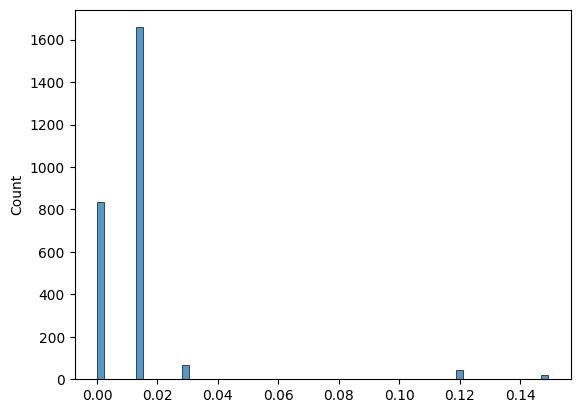

In [23]:
sns.histplot(df.apply(lambda df: df.isnull().sum()/len(df), axis=1))

Maximo ratio per row is 0.15, OK!

In [24]:
print(df[df['Red Arrow']==0].count()[0])
print(df[df['Red Arrow']==1].count()[0])

print(df[df['Green Arrow']==0].count()[0])
print(df[df['Green Arrow']==1].count()[0])

2567
39
2567
39


In [25]:
#deleting the two category columns because they are too unbalanced
#df_nonan = df.drop(['Red Arrow', 'Green Arrow'], axis=1)

In [26]:
df['Red Arrow'].loc[df['Red Arrow'].isna()==True] = 0

In [27]:
df['Green Arrow'].loc[df['Green Arrow'].isna()==True] = 0

(array([ 30.,   0.,   0.,  31., 369., 395.,   0.,   0.,   0.,  30.]),
 array([-29.9 , -23.38, -16.86, -10.34,  -3.82,   2.7 ,   9.22,  15.74,
         22.26,  28.78,  35.3 ]),
 <BarContainer object of 10 artists>)

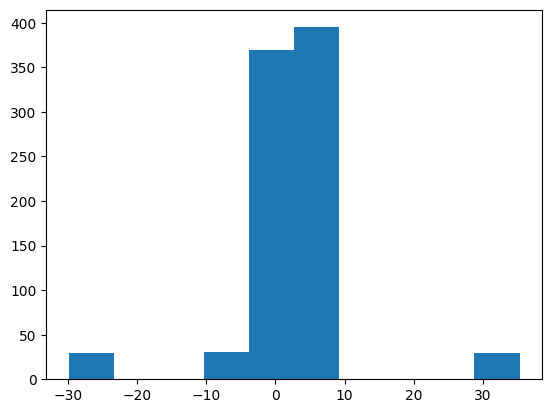

In [29]:
plt.hist(df['Value_USreal'])

In [30]:
df['ratio_met'].describe()

count    2.539000e+03
mean     1.521253e+10
std      1.621965e+10
min      1.682145e+05
25%      4.626014e+09
50%      1.107878e+10
75%      2.022772e+10
max      1.482387e+11
Name: ratio_met, dtype: float64

In [31]:
df['ratio_met'].loc[df['ratio_met'].isna()==True] = np.mean(df['ratio_met'])

In [32]:
df['Value_USreal'].loc[df['Value_USreal'].isna()==True] = np.mean(df['Value_USreal'])

In [33]:
#df_nonan.drop('ratio_met', axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2626 entries, 0 to 2625
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2626 non-null   datetime64[ns]
 1   open                        2626 non-null   float64       
 2   high                        2626 non-null   float64       
 3   low                         2626 non-null   float64       
 4   close                       2626 non-null   float64       
 5   Upper Bollinger             2626 non-null   float64       
 6   Lower Bollinger             2626 non-null   float64       
 7   Upper Donchian              2626 non-null   float64       
 8   Lower Donchian              2626 non-null   float64       
 9   Volume                      2626 non-null   float64       
 10  Red Arrow                   2626 non-null   float64       
 11  Green Arrow                 2626 non-null   float64     

In [35]:
# columns: Value_M3, _CPI, _EFF, _SP500, _USpce 
# nans from 2023-03-02 to 2023-04-26 -> drop all rows --> new final date 2023-03-01

df_nonan = df.iloc[:2558]

In [36]:
# column: Value_USreal --> too many nans, drop column, ask Roy

#df_nonan.drop('Value_USreal', axis=1, inplace=True)

In [37]:
df_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 0 to 2557
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2558 non-null   datetime64[ns]
 1   open                        2558 non-null   float64       
 2   high                        2558 non-null   float64       
 3   low                         2558 non-null   float64       
 4   close                       2558 non-null   float64       
 5   Upper Bollinger             2558 non-null   float64       
 6   Lower Bollinger             2558 non-null   float64       
 7   Upper Donchian              2558 non-null   float64       
 8   Lower Donchian              2558 non-null   float64       
 9   Volume                      2558 non-null   float64       
 10  Red Arrow                   2558 non-null   float64       
 11  Green Arrow                 2558 non-null   float64     

In [38]:
df_nonan.to_csv('/Users/ireneberros/Documents/model/data/df_nonan.csv', index=False)

# Feature Engineering

In [39]:
df_nonan = pd.read_csv('/Users/ireneberros/Documents/model/data/df_nonan.csv')
df_nonan['time'] = pd.to_datetime(df_nonan['time'])
df_nonan.set_index('time', inplace=True)

# Date features
# df_nonan['time'] = pd.to_datetime(df_nonan['time'])
# df_nonan["fe_month"] = df_nonan['time'].dt.month
# df_nonan["fe_weekofyear"] = df_nonan['time'].dt.isocalendar().week.astype(int)
# df_nonan["fe_quarter"] = df_nonan['time'].dt.quarter
# df_nonan["fe_is_month_start"] = df_nonan['time'].dt.is_month_start.astype(int)
# df_nonan["fe_is_month_end"] = df_nonan['time'].dt.is_month_end.astype(int)

# new feat from price
df_nonan['log_price'] = np.log(df_nonan['close'].astype(float))
df_nonan['returns'] = df_nonan['close'].astype(float).pct_change().dropna() *100
df_nonan['log_return'] = df_nonan['log_price'] - df_nonan['log_price'].shift(1)

df_nonan['HL_sprd'] = np.log((df_nonan.high - df_nonan.low) / df_nonan.close)
df_nonan['CO_sprd'] = (df_nonan.close - df_nonan.open) / df_nonan.open
df_nonan['Volume'] = np.log(df_nonan.Volume) 

#df_nonan['Bollinger'] = np.log((df_nonan['Upper Bollinger'] - df_nonan['Lower Bollinger']) / df_nonan.close)
#df_nonan['Donchian'] = (df_nonan['Upper Donchian'] - df_nonan['Lower Donchian']) / df_nonan.close

In [40]:
#intervalos anchoring_idx
# A = 60k +- 60*0.04
# B = 50k +- 50*0.04
# C = 40k +- 40*0.04
# D = 30k +- 30*0.04
# E = 20k +- 20*0.04
# F = 10k +- 10*0.04


In [41]:
# df_nonan['Anchoring_idx_A'] = df_nonan['close'].apply(lambda x: 1 if x<(60000+(60000*0.04)) and x>(60000-(60000*0.04)) else 0)
# df_nonan['Anchoring_idx_B'] = df_nonan['close'].apply(lambda x: 1 if x<(50000+(50000*0.04)) and x>(50000-(50000*0.04)) else 0)
# df_nonan['Anchoring_idx_C'] = df_nonan['close'].apply(lambda x: 1 if x<(40000+(40000*0.04)) and x>(40000-(40000*0.04)) else 0)
# df_nonan['Anchoring_idx_D'] = df_nonan['close'].apply(lambda x: 1 if x<(30000+(30000*0.04)) and x>(30000-(30000*0.04)) else 0)
# df_nonan['Anchoring_idx_E'] = df_nonan['close'].apply(lambda x: 1 if x<(20000+(20000*0.04)) and x>(20000-(20000*0.04)) else 0)
# df_nonan['Anchoring_idx_F'] = df_nonan['close'].apply(lambda x: 1 if x<(10000+(10000*0.04)) and x>(10000-(10000*0.04)) else 0)

In [42]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df_nonan.drop(['open', 'high', 'low', 'close', 'Lower Bollinger',
       'Upper Donchian', 'Lower Donchian'], axis=1, inplace=True)


### Volatility

In [43]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df_nonan.log_return.rolling(window=i)\
                         .apply(um.realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df_nonan.index)

Let's try first 30 days

In [44]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df_nonan['vol_current'] = df_nonan.log_return.rolling(window=INTERVAL_WINDOW)\
                                   .apply(um.realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df_nonan['vol_future'] = df_nonan.log_return.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(um.realized_volatility_daily)

In [45]:
df_nonan.describe()

Upper Bollinger       Volume    Red Arrow  Green Arrow          RSI  \
count      2558.000000  2558.000000  2558.000000  2558.000000  2558.000000   
mean      17571.693473     8.541799     0.014855     0.014855    53.586380   
std       18520.462393     0.898575     0.120998     0.120998    14.226812   
min         420.353195     3.062479     0.000000     0.000000     9.632983   
25%        4331.154580     7.903170     0.000000     0.000000    43.692198   
50%        9986.003155     8.602975     0.000000     0.000000    52.632883   
75%       23673.014855     9.185866     0.000000     0.000000    62.850820   
max       68891.603000    11.169891     1.000000     1.000000    94.020499   

       Put-call Ratio  Detrended Price Oscillator   ratio_mvrv     ratio_met  \
count     2558.000000                 2558.000000  2558.000000  2.558000e+03   
mean       430.512705                  189.135046     1.816908  1.502877e+10   
std        432.576122                 3764.206269     0.701691  1.569924e+10   
min          0.610000               -20204.532857     0.699270  1.682145e+05   
25%          1.027000                 -766.345476     1.308447  4.686767e+09   
50%        614.000000                   42.142381     1.694712  1.174907e+10   
75%        862.000000                 1077.863810     2.177213  1.998841e+10   
max        999.000000                21465.031905     4.850245  1.482387e+11   

         ratio_nvt  ...  stock-to-flow  active-3y-5y-btc  active-5y-7y-btc  \
count  2558.000000  ...    2558.000000      2.558000e+03      2.558000e+03   
mean     25.092327  ...   35668.245018      2.029045e+06      1.109915e+06   
std      15.668259  ...   44598.363200      6.598211e+05      3.536150e+05   
min       0.795160  ...     415.472196      8.321829e+05      5.541065e+05   
25%      11.902694  ...    5597.454326      1.520621e+06      8.194549e+05   
50%      23.353896  ...    8181.002763      2.058563e+06      1.088905e+06   
75%      33.001133  ...  100611.867473      2.538779e+06      1.278960e+06   
max      98.524587  ...  111723.207855      3.213435e+06      1.925304e+06   

         log_price      returns   log_return      HL_sprd      CO_sprd  \
count  2558.000000  2557.000000  2557.000000  2558.000000  2558.000000   
mean      8.963447     0.234364     0.001562    -3.141547     0.002382   
std       1.363249     3.931831     0.039653     0.717238     0.039309   
min       5.991039   -38.980058    -0.493969    -6.337447    -0.391466   
25%       8.273629    -1.396104    -0.014059    -3.596472    -0.013876   
50%       9.105440     0.173139     0.001730    -3.113447     0.001741   
75%       9.958158     1.869251     0.018520    -2.677850     0.018920   
max      11.120757    26.921124     0.238396    -0.416202     0.269043   

       vol_current   vol_future  
count  2528.000000  2522.000000  
mean      0.037116     0.037177  
std       0.016265     0.016236  
min       0.006711     0.006711  
25%       0.027254     0.027331  
50%       0.034791     0.034819  
75%       0.045478     0.045502  
max       0.110288     0.110288  

[8 rows x 66 columns]

In [46]:
# DROPPING ALL NaN VALUES
df_nonan.dropna(inplace=True)

# Multivariate Analysis

In [47]:
features = [
    'log_return',
 'ratio-mvrv',
 'ratio_mvrv',
 'size_tran',
 'block_size',
 'returns',
 'vol_current',
 'realized-price-usd',
 'price-usd',
 'block-height',
 'supply-btc',
 'rev_all_miners',
 'block_reward',
 'trans_fees',
 'thermocap-usd',
 'z-score',
 'unrealized-profit',
 'balance-1',
 'balance-0-01',
 'Upper Bollinger',
 'number-of-utxos',
 'ratio_stf',
 'mining-difficulty',
 'log_price',
 'stock-to-flow',
 'vol_future'
]

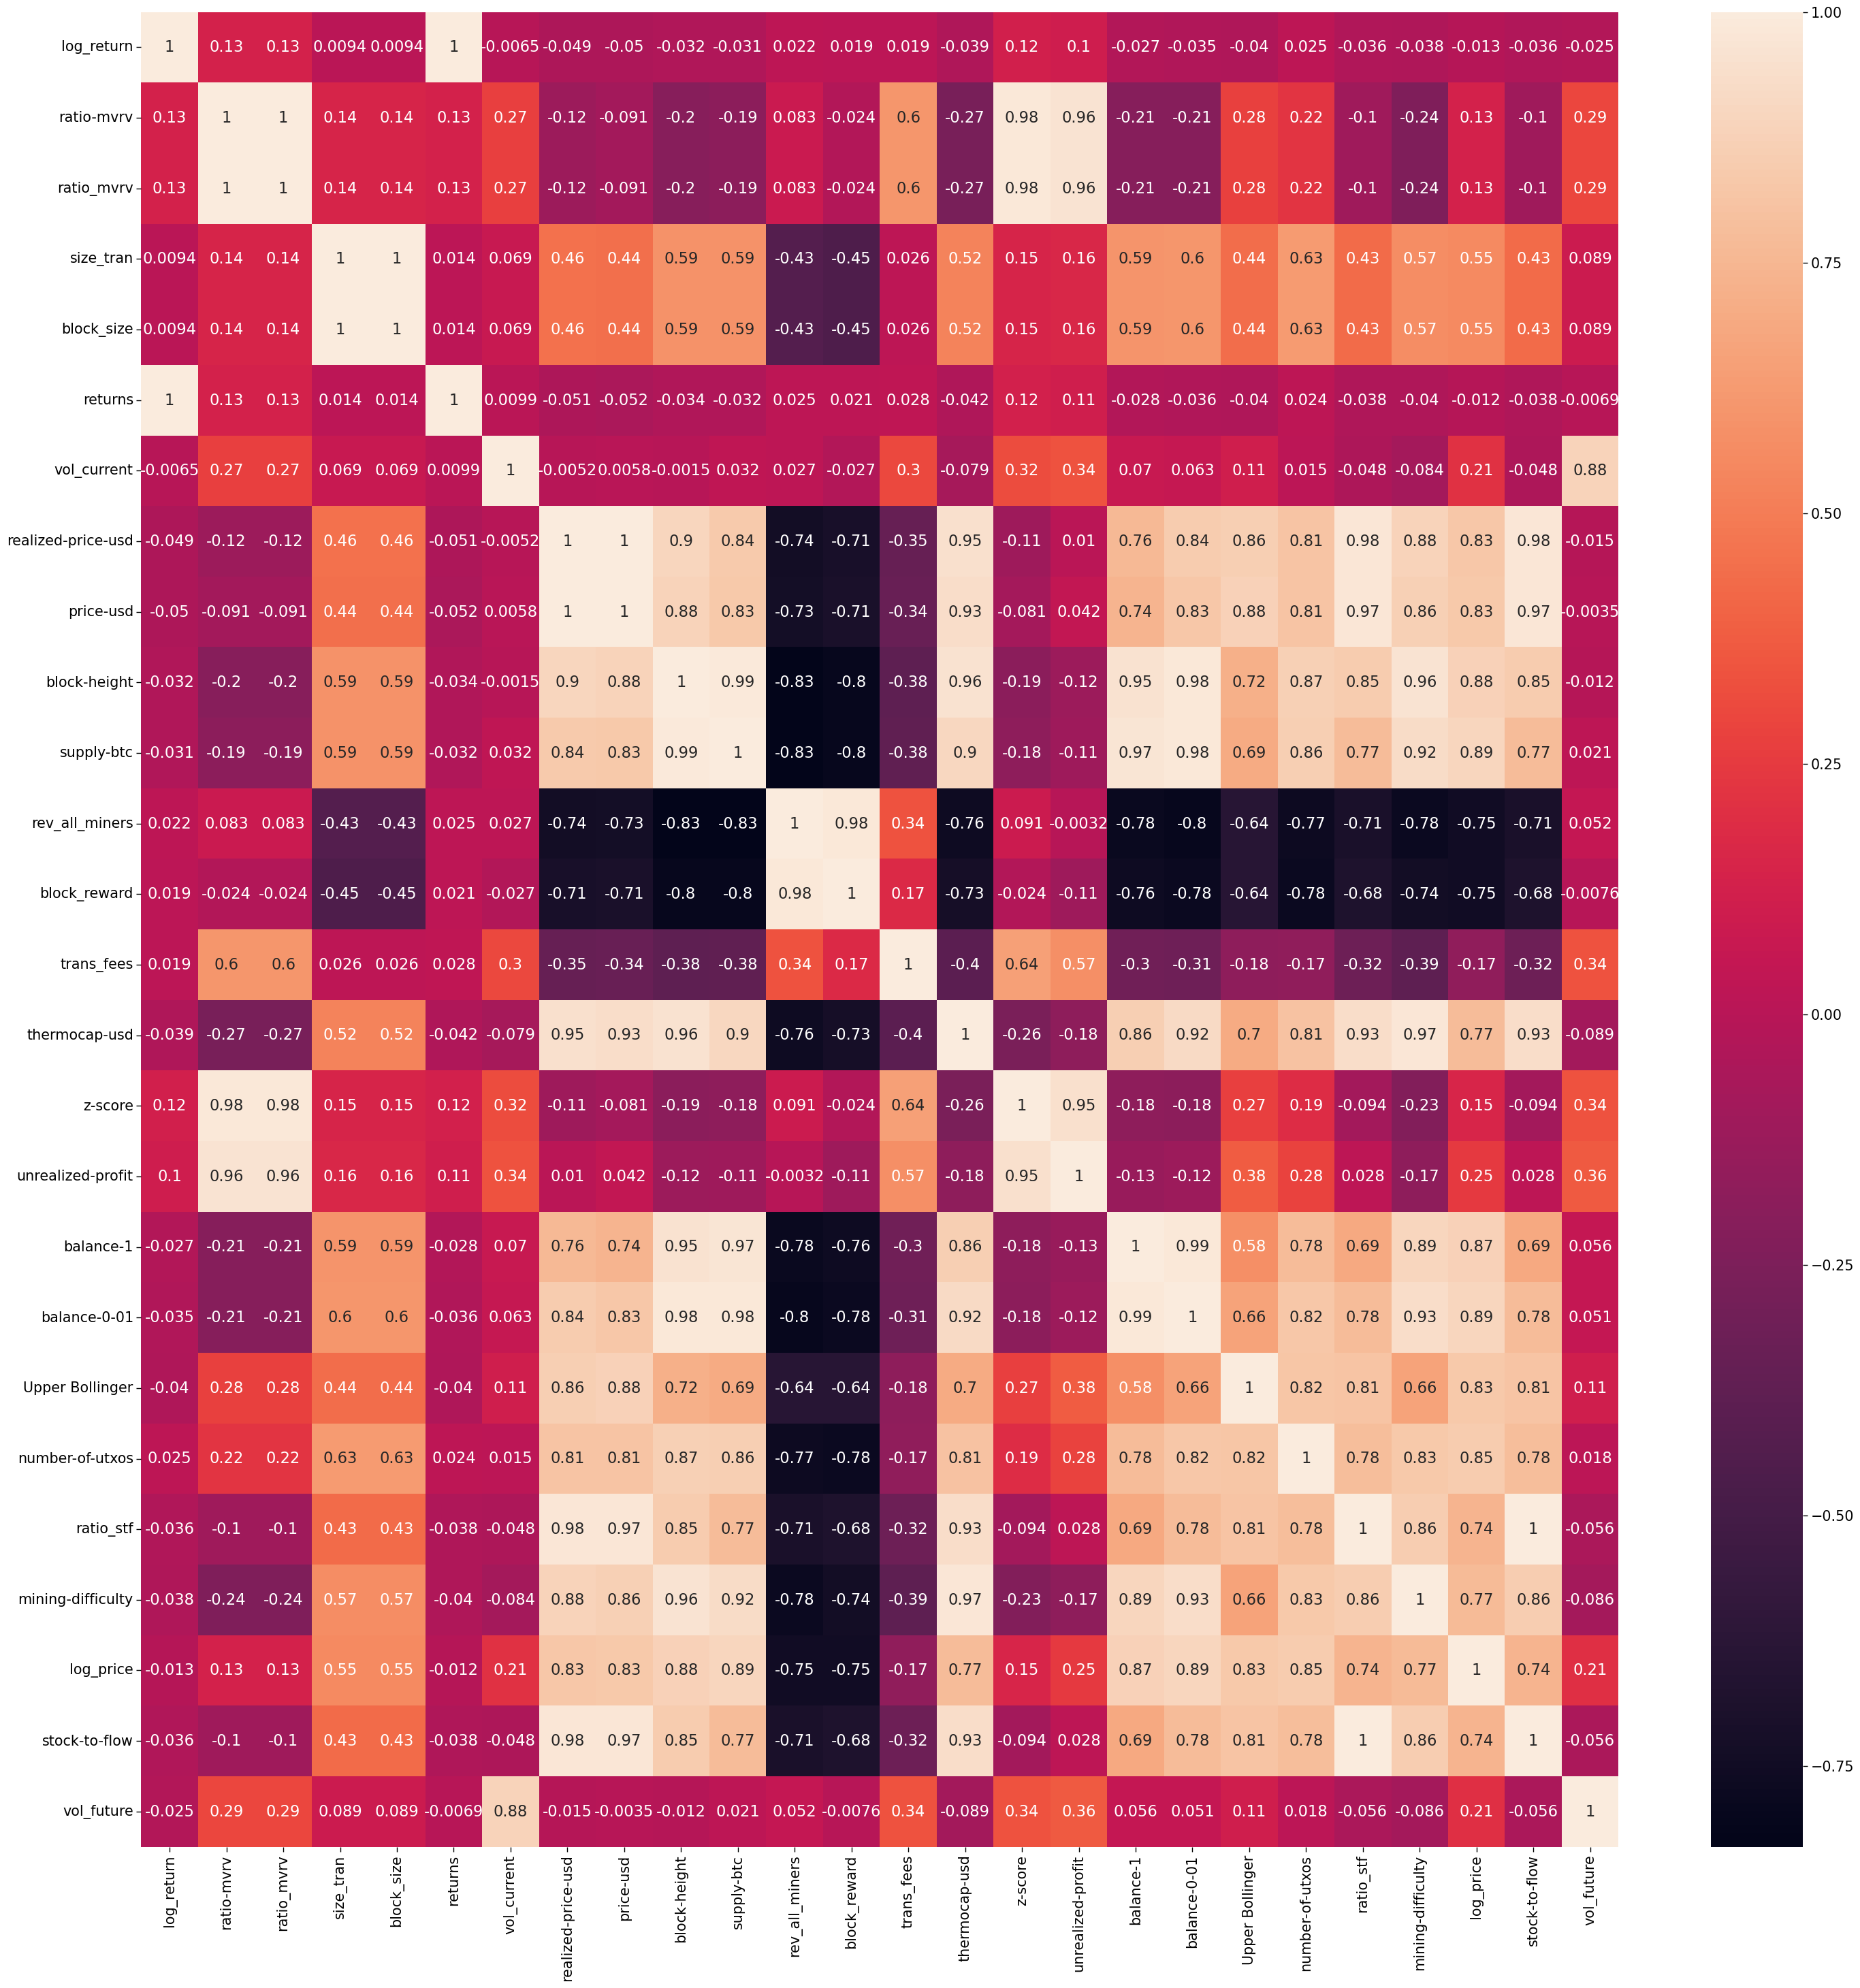

In [41]:
plt.figure(figsize=(35,35))
sns.heatmap(df_nonan[features].corr(), annot=True)
plt.show()

In [48]:
df_nonan.drop(['returns'], axis=1, inplace=True)

In [49]:
# Assuming df is your DataFrame

# Compute the correlation matrix
corr = df_nonan.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to get the lower triangle of the correlation matrix
corr_lower = corr.where(~mask)

# Find pairs of columns that have a correlation of 0.8 or higher, or -0.8 or lower
high_corr_pairs = [(c1, c2, corr_lower[c1][c2]) for c1 in corr_lower.columns for c2 in corr_lower.index if (abs(corr_lower[c1][c2]) > 0.8) and (c1 != c2)]

print("Highly correlated pairs with correlation values:")
for pair in high_corr_pairs:
    print(pair)

Highly correlated pairs with correlation values:
('Upper Bollinger', 'ratio_stf', 0.8131146139356215)
('Upper Bollinger', 'price-usd', 0.8779575125530458)
('Upper Bollinger', 'delta-cap-usd', 0.9023612589280446)
('Upper Bollinger', 'capitalization', 0.861622327840955)
('Upper Bollinger', 'market-cap-usd', 0.9888096555590051)
('Upper Bollinger', 'balance-10k', -0.8263282591813853)
('Upper Bollinger', 'number-of-utxos', 0.8174125789379253)
('Upper Bollinger', 'cap-usd', 0.8513380725519815)
('Upper Bollinger', 'realized-price-usd', 0.8570222979795947)
('Upper Bollinger', 'stock-to-flow', 0.8131146139356215)
('Upper Bollinger', 'log_price', 0.8301918970478179)
('ratio_mvrv', 'ratio-mvrv', 1.0)
('ratio_mvrv', 'z-score', 0.9835850795277041)
('ratio_mvrv', 'price-drawdown', 0.9321632135589786)
('ratio_mvrv', 'unrealized-profit', 0.9613378901136431)
('ratio_stf', 'Value_USpce', 0.9269684144422478)
('ratio_stf', 'hash_rate', 0.8454318666814644)
('ratio_stf', 'thermocap-usd', 0.9301954462012899)

In [53]:
df_nonan_corr = df_nonan.drop(['Upper Bollinger', 'ratio_stf', 'Value_USpce', 'hash_rate', 'active_addre', 'tran_sec',
               'size_tran', 'rev_all_miners', 'supply-btc', 'thermocap-usd', 'price-usd', 'block-height', 'destroyed-cvdd',
               'delta-cap-usd', 'capitalization', 'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc', 'mining-difficulty', 
               'z-score', 'balance-0-1', 'balance-0-01', 'balance-1', 'number-of-addresses', 'balance-1k', 'number-of-utxos',
               'active-3y-5y-btc', 'price-drawdown', 'cap-usd','realized-price-usd'], axis=1)

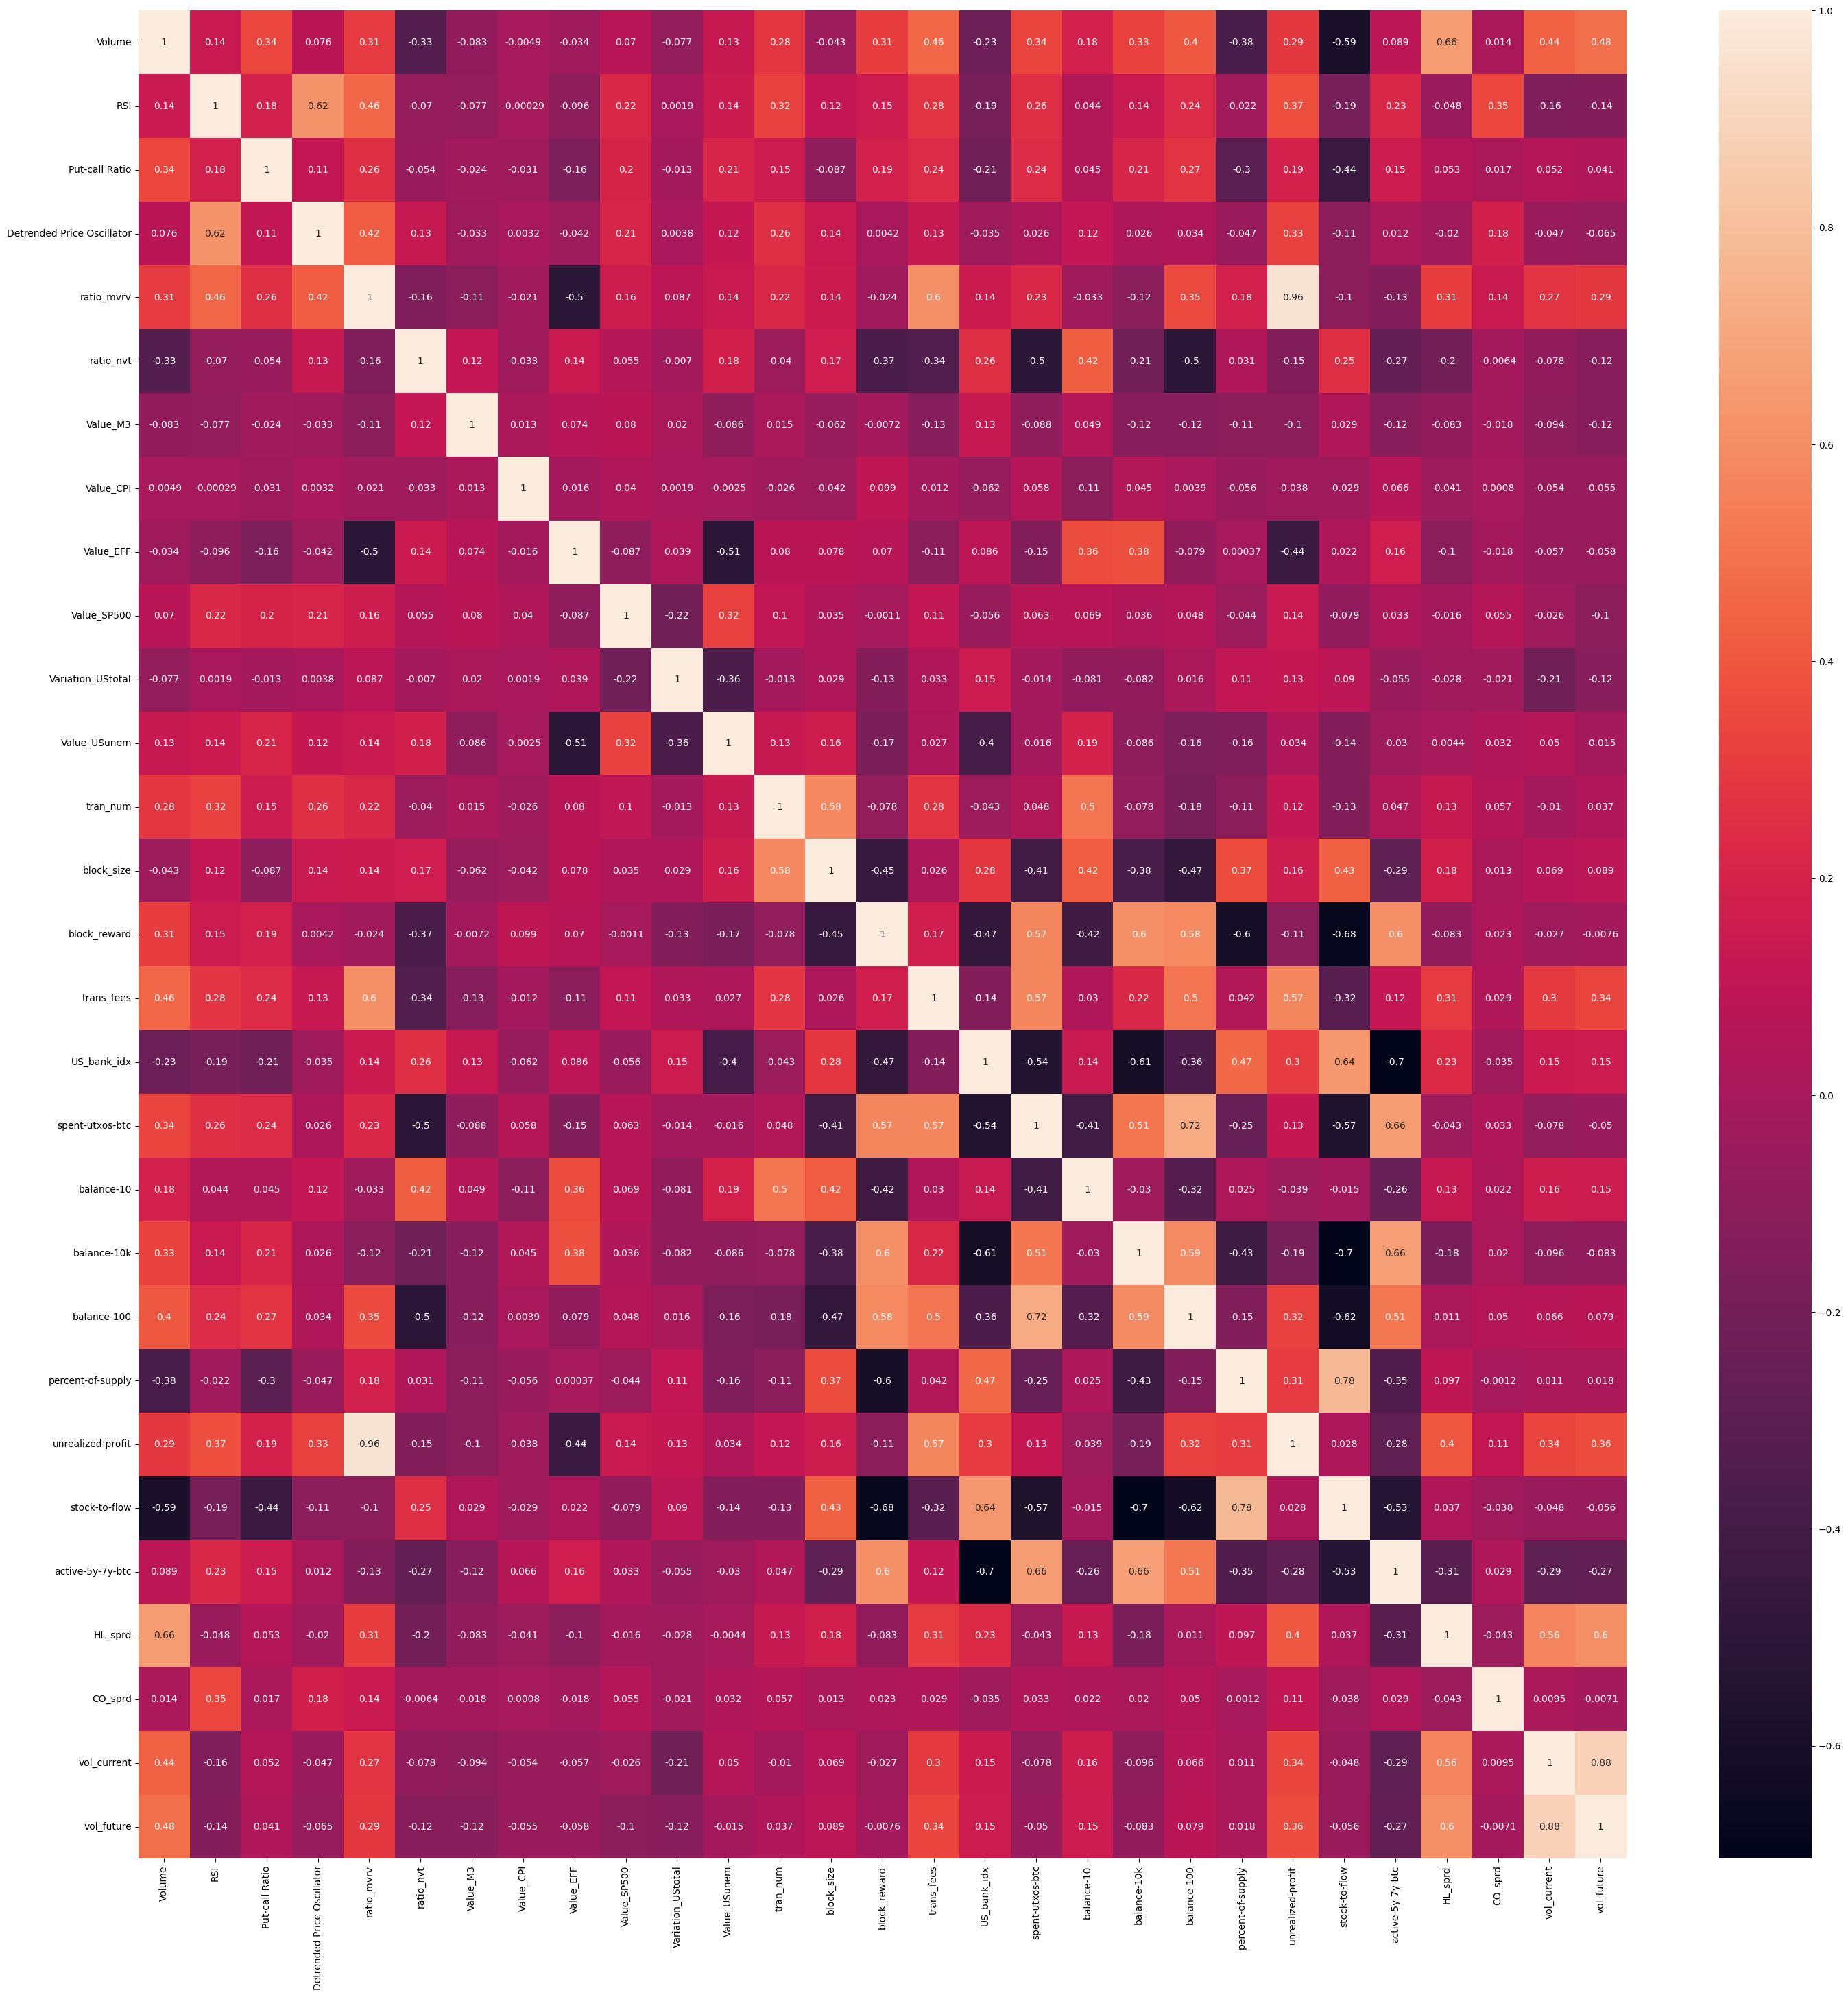

In [45]:
plt.figure(figsize=(35,35))
sns.heatmap(df_nonan_corr.corr(), annot=True)
plt.show()

In [54]:
# Assuming df is your DataFrame

# Compute the correlation matrix
corr = df_nonan_corr.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to get the lower triangle of the correlation matrix
corr_lower = corr.where(~mask)

# Find pairs of columns that have a correlation of 0.8 or higher, or -0.8 or lower
high_corr_pairs = [(c1, c2, corr_lower[c1][c2]) for c1 in corr_lower.columns for c2 in corr_lower.index if (abs(corr_lower[c1][c2]) > 0.65) and (c1 != c2)]

print("Highly correlated pairs with correlation values:")
for pair in high_corr_pairs:
    print(pair)

Highly correlated pairs with correlation values:
('Volume', 'HL_sprd', 0.6551322704045394)
('ratio_mvrv', 'unrealized-profit', 0.9613378901136431)
('block_reward', 'stock-to-flow', -0.6824174056002855)
('block_reward', 'log_price', -0.7502592876842694)
('US_bank_idx', 'active-5y-7y-btc', -0.7014869068025269)
('US_bank_idx', 'log_price', 0.7470758521661219)
('spent-utxos-btc', 'balance-100', 0.716945820669782)
('spent-utxos-btc', 'active-5y-7y-btc', 0.6556569304007027)
('spent-utxos-btc', 'log_price', -0.7620830481820359)
('balance-10k', 'stock-to-flow', -0.7040288784702831)
('balance-10k', 'active-5y-7y-btc', 0.6635522621850062)
('balance-10k', 'log_price', -0.7164301351794728)
('balance-100', 'log_price', -0.7281416981319682)
('percent-of-supply', 'stock-to-flow', 0.7750569124211572)
('stock-to-flow', 'log_price', 0.736802275927691)
('active-5y-7y-btc', 'log_price', -0.8602267835294143)
('log_return', 'CO_sprd', 0.9972670166559683)
('vol_current', 'vol_future', 0.8806276745636071)


In [55]:
df_final_corr = df_nonan_corr.drop(['stock-to-flow', 'active-5y-7y-btc', 'spent-utxos-btc'], axis=1)

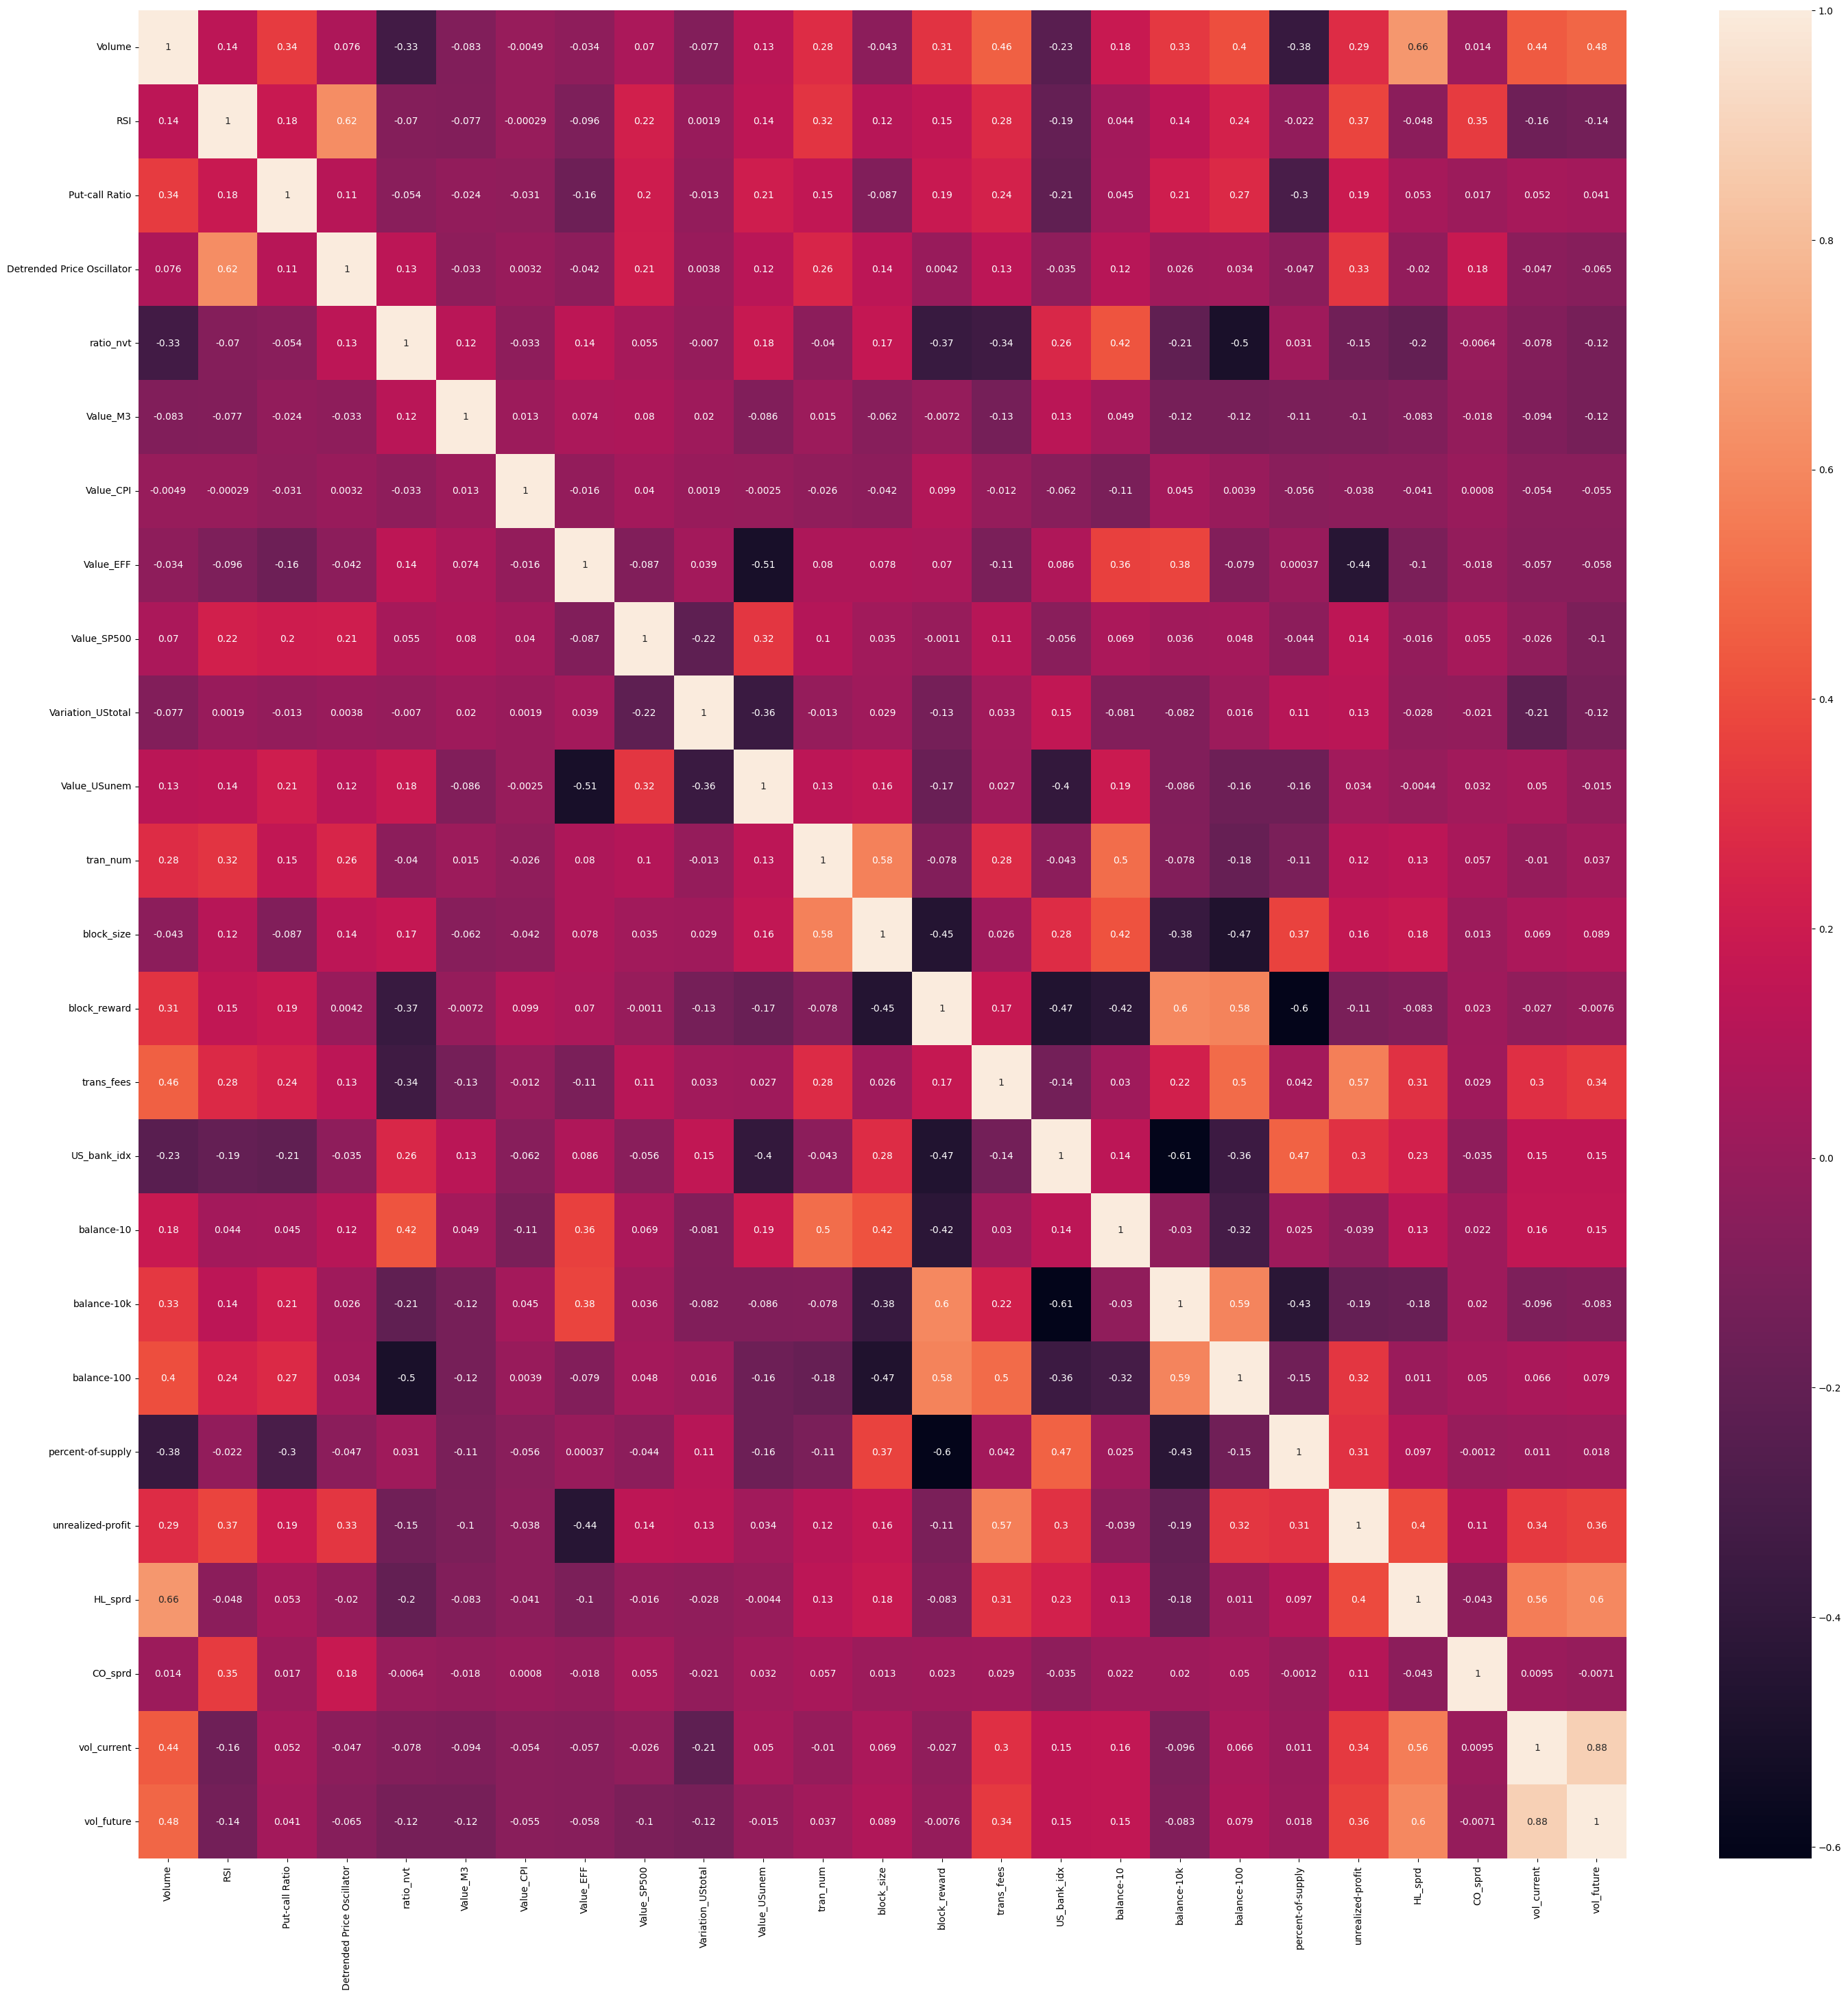

In [27]:
plt.figure(figsize=(35,35))
sns.heatmap(df_final_corr.corr(), annot=True)
plt.show()

In [56]:
df_final_corr.to_csv('/Users/ireneberros/Documents/model/data/df_final.csv', index=True)

# Train test splits

In [57]:
#df = pd.read_csv('/Users/ireneberros/Documents/model/data/df_final.csv')
df = df_nonan.copy()
#df['time'] = pd.to_datetime(df['time'])
#df.set_index('time', inplace=True)

In [58]:
df.columns

Index(['Upper Bollinger', 'Volume', 'Red Arrow', 'Green Arrow', 'RSI',
       'Put-call Ratio', 'Detrended Price Oscillator', 'ratio_mvrv',
       'ratio_met', 'ratio_nvt', 'ratio_stf', 'Value_M3', 'Value_CPI',
       'Value_EFF', 'Value_SP500', 'Value_USpce', 'Value_USreal',
       'Variation_UStotal', 'Value_USunem', 'hash_rate', 'active_addre',
       'tran_sec', 'tran_num', 'block_size', 'rev_all_miners', 'block_reward',
       'size_tran', 'trans_fees', 'US_bank_idx', 'thermocap-usd', 'price-usd',
       'block-height', 'supply-btc', 'destroyed-cvdd', 'delta-cap-usd',
       'capitalization', 'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc',
       'spent-utxos-btc', 'mining-difficulty', 'z-score', 'balance-0-1',
       'balance-0-01', 'balance-1', 'balance-1k', 'balance-10', 'balance-10k',
       'balance-100', 'number-of-addresses', 'number-of-utxos',
       'percent-of-supply', 'price-drawdown', 'cap-usd', 'realized-price-usd',
       'unrealized-profit', 'stock-to-flow', 'a

In [59]:
#update numerical & target features

target = ['vol_future']
numerical_feat = df.drop('vol_future', axis=1).columns

In [60]:
# validation/test splits
test_size = 30
val_size = 365

# to index
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [61]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2016-03-30 00:00:00 	to: 2022-01-23 00:00:00 	2126 days
VALIDATION 	From: 2022-01-24 00:00:00 	to: 2023-01-23 00:00:00 	365 days
TEST 		From: 2023-01-24 00:00:00 	to: 2023-02-22 00:00:00 	30 days


In [62]:
# Y (target) 3 splits
y_train = df.loc[train_idx][target]
y_val = df.loc[val_idx][target]
y_test = df.loc[test_idx][target]

In [63]:
# X 3 splits
x_train = df.loc[train_idx].drop('vol_future', axis=1)
x_val = df.loc[val_idx].drop('vol_future', axis=1)
x_test = df.loc[test_idx].drop('vol_future', axis=1)

In [64]:
# for visualization
x_train_vol = df.vol_current[train_idx]
x_val_vol = df.vol_current[val_idx]
x_test_vol = df.vol_current[test_idx]

In [65]:
print(len(y_train), len(x_train))
print(len(y_val), len(x_val))
print(len(y_test), (len(x_test)))

2126 2126
365 365
30 30


In [66]:
y_train.describe()

vol_future
count  2126.000000
mean      0.038098
std       0.016986
min       0.006711
25%       0.027734
50%       0.035705
75%       0.047482
max       0.110288

In [67]:
x_train.describe()

Upper Bollinger       Volume    Red Arrow  Green Arrow          RSI  \
count      2126.000000  2126.000000  2126.000000  2126.000000  2126.000000   
mean      15512.592521     8.742340     0.013641     0.014111    54.637769   
std       18829.954309     0.794928     0.116021     0.117976    14.309208   
min         421.521771     3.614623     0.000000     0.000000     9.632983   
25%        3980.376163     8.212119     0.000000     0.000000    44.612956   
50%        8883.166872     8.772703     0.000000     0.000000    53.975590   
75%       12897.865197     9.313856     0.000000     0.000000    64.439103   
max       68891.603000    11.169891     1.000000     1.000000    94.020499   

       Put-call Ratio  Detrended Price Oscillator   ratio_mvrv     ratio_met  \
count     2126.000000                 2126.000000  2126.000000  2.126000e+03   
mean       510.204869                  414.406790     1.944446  1.463384e+10   
std        425.833499                 3753.302396     0.689377  1.468170e+10   
min          0.610000               -20204.532857     0.699270  1.682145e+05   
25%          1.082000                 -410.758095     1.453777  5.403756e+09   
50%        761.000000                   65.263333     1.802021  1.318962e+10   
75%        884.000000                 1066.630952     2.332417  1.987372e+10   
max        999.000000                21465.031905     4.850245  1.385966e+11   

         ratio_nvt  ...  realized-price-usd  unrealized-profit  stock-to-flow  \
count  2126.000000  ...         2126.000000        2126.000000    2126.000000   
mean     24.821227  ...         6641.222108           0.506599   22462.670845   
std      14.033573  ...         6651.949132           0.108418   34739.910350   
min       2.016091  ...          309.403103           0.305923     425.348275   
25%      12.430804  ...         1628.219604           0.421030    5521.573607   
50%      24.178882  ...         5223.651941           0.488592    7542.383443   
75%      32.664909  ...         6072.108509           0.587333   14246.969140   
max      87.176566  ...        24590.759778           0.793415  111085.802881   

       active-3y-5y-btc  active-5y-7y-btc    log_price   log_return  \
count      2.126000e+03      2.126000e+03  2126.000000  2126.000000   
mean       1.922895e+06      1.123149e+06     8.785141     0.002102   
std        6.555646e+05      3.452791e+05     1.344330     0.041032   
min        8.321829e+05      5.541065e+05     6.025238    -0.493969   
25%        1.225167e+06      8.464422e+05     8.179592    -0.014156   
50%        1.894419e+06      1.099468e+06     8.957949     0.002128   
75%        2.460796e+06      1.276094e+06     9.370798     0.020362   
max        3.213435e+06      1.855265e+06    11.120757     0.238396   

           HL_sprd      CO_sprd  vol_current  
count  2126.000000  2126.000000  2126.000000  
mean     -3.101320     0.002985     0.038034  
std       0.720664     0.040678     0.017051  
min      -6.337447    -0.391466     0.006711  
25%      -3.563481    -0.013925     0.027650  
50%      -3.067326     0.002073     0.035705  
75%      -2.628824     0.020833     0.047482  
max      -0.416202     0.269043     0.110288  

[8 rows x 64 columns]

In [68]:
# scale data
scaler_vol = MinMaxScaler()

scaler_vol = scaler_vol.fit(x_train_vol.values.reshape(-1,1))

In [69]:
x_train_scaled = um.transform_volatility_to_scaler(scaler_vol, x_train_vol)
y_train_scaled = um.transform_volatility_to_scaler(scaler_vol, y_train)

x_val_scaled = um.transform_volatility_to_scaler(scaler_vol, x_val_vol)
y_val_scaled = um.transform_volatility_to_scaler(scaler_vol, y_val)

x_test_scaled = um.transform_volatility_to_scaler(scaler_vol, x_test_vol)
y_test_scaled = um.transform_volatility_to_scaler(scaler_vol, y_test)

In [70]:
y_train.head(10)

vol_future
time                  
2016-03-30    0.008703
2016-03-31    0.008655
2016-04-01    0.008695
2016-04-02    0.008593
2016-04-03    0.008479
2016-04-04    0.007874
2016-04-05    0.007913
2016-04-06    0.007896
2016-04-07    0.007898
2016-04-08    0.008139

In [71]:
y_train_scaled.head(10)

time
2016-03-30    0.019235
2016-03-31    0.018776
2016-04-01    0.019153
2016-04-02    0.018171
2016-04-03    0.017077
2016-04-04    0.011229
2016-04-05    0.011612
2016-04-06    0.011447
2016-04-07    0.011458
2016-04-08    0.013793
dtype: float64

In [72]:
x_train_scaled.head(10)

time
2016-03-30    0.055122
2016-03-31    0.054657
2016-04-01    0.048704
2016-04-02    0.048496
2016-04-03    0.035249
2016-04-04    0.028440
2016-04-05    0.025576
2016-04-06    0.019235
2016-04-07    0.018776
2016-04-08    0.019153
dtype: float64

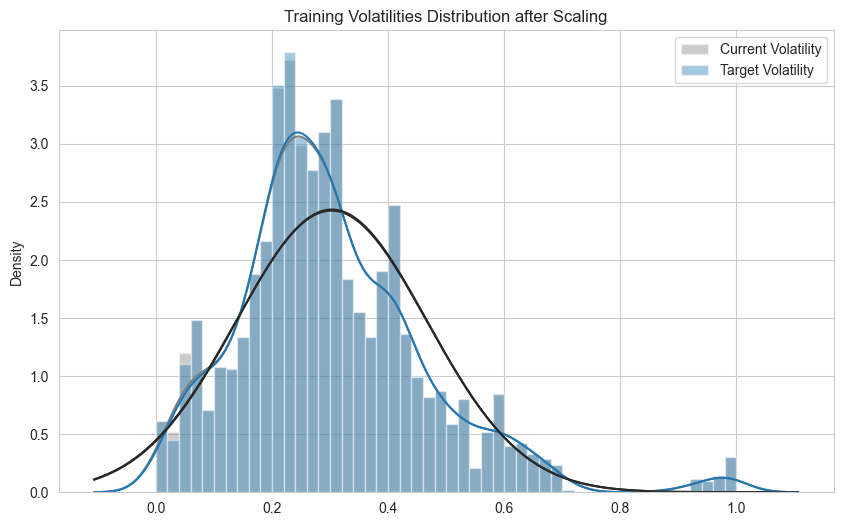

In [73]:
# volatility after scaling 
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show()

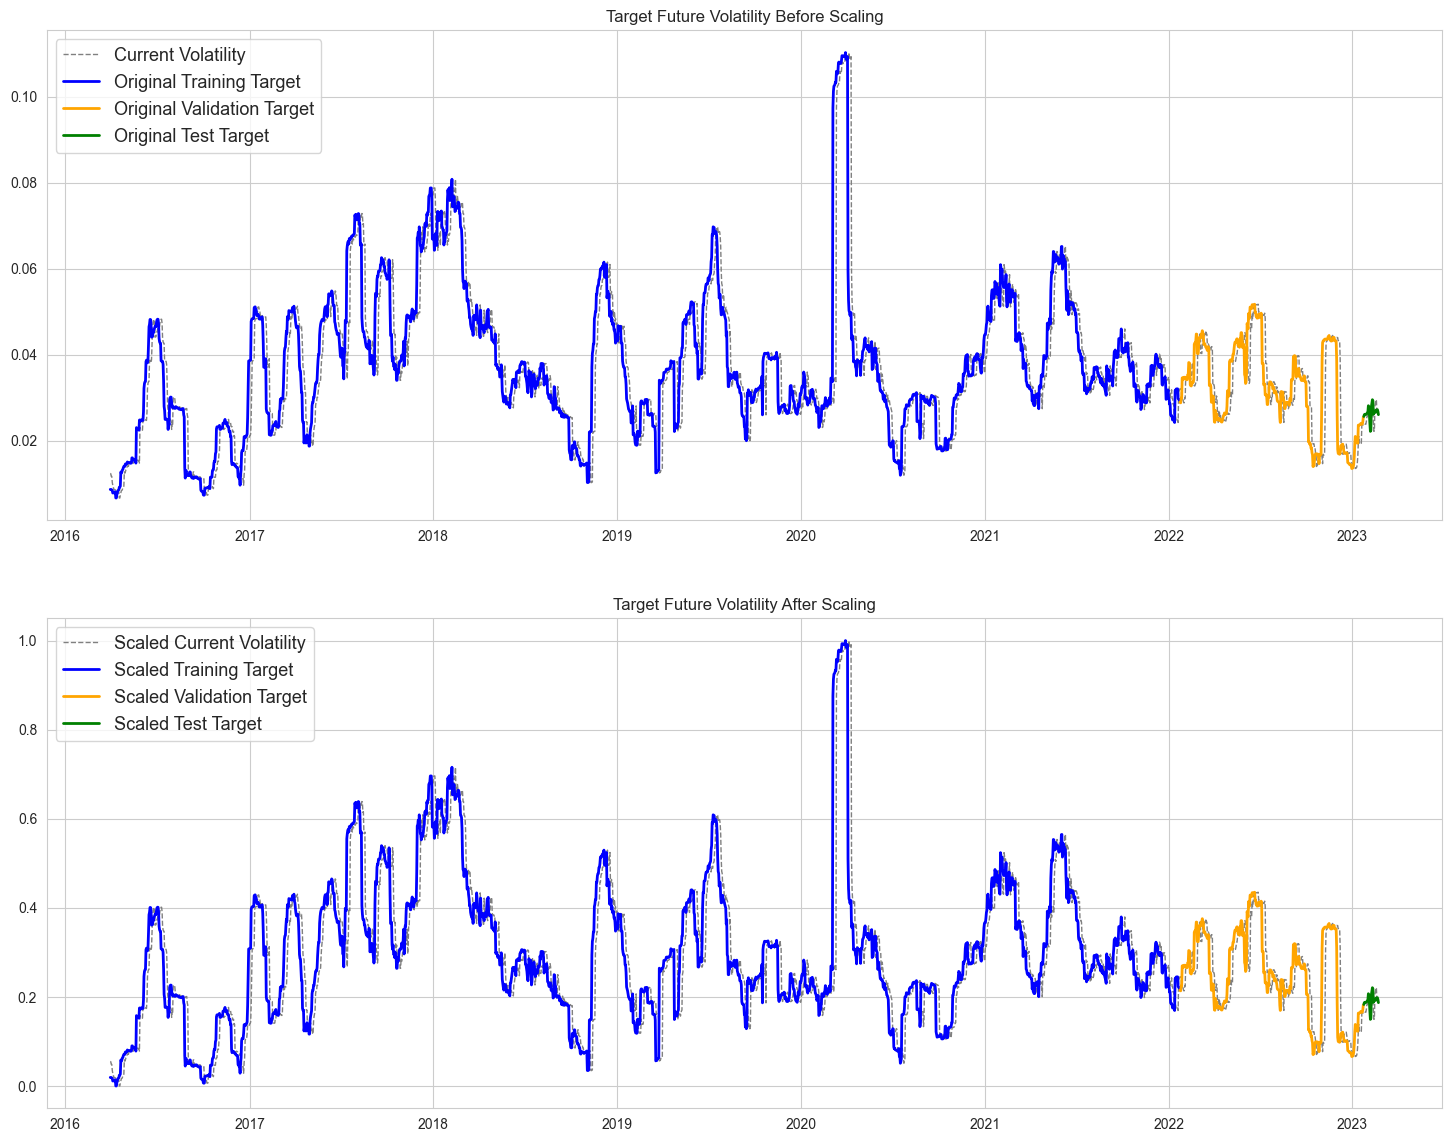

In [74]:
# plot splits train-val-test

with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(um.transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show()

# Features importance
* Lineal regression importances first approach

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE


# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBModel as xgb

#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [76]:
# Features/target split
X = df.drop(target, axis=1)
y = df[target]

x_transf = X.copy()
x_val_transf = x_val.copy()

# Standarize the data to improve the regression's performance
scaler = MinMaxScaler()
x_transf[numerical_feat] = scaler.fit_transform(X[numerical_feat])
x_val_transf[numerical_feat] = scaler.transform(x_val[numerical_feat])

In [77]:
# Feature importance RFE with linear regression
model = LinearRegression( n_jobs=-1)
selector = RFE(model, n_features_to_select=5, step=1)
selector = selector.fit(x_transf, y)

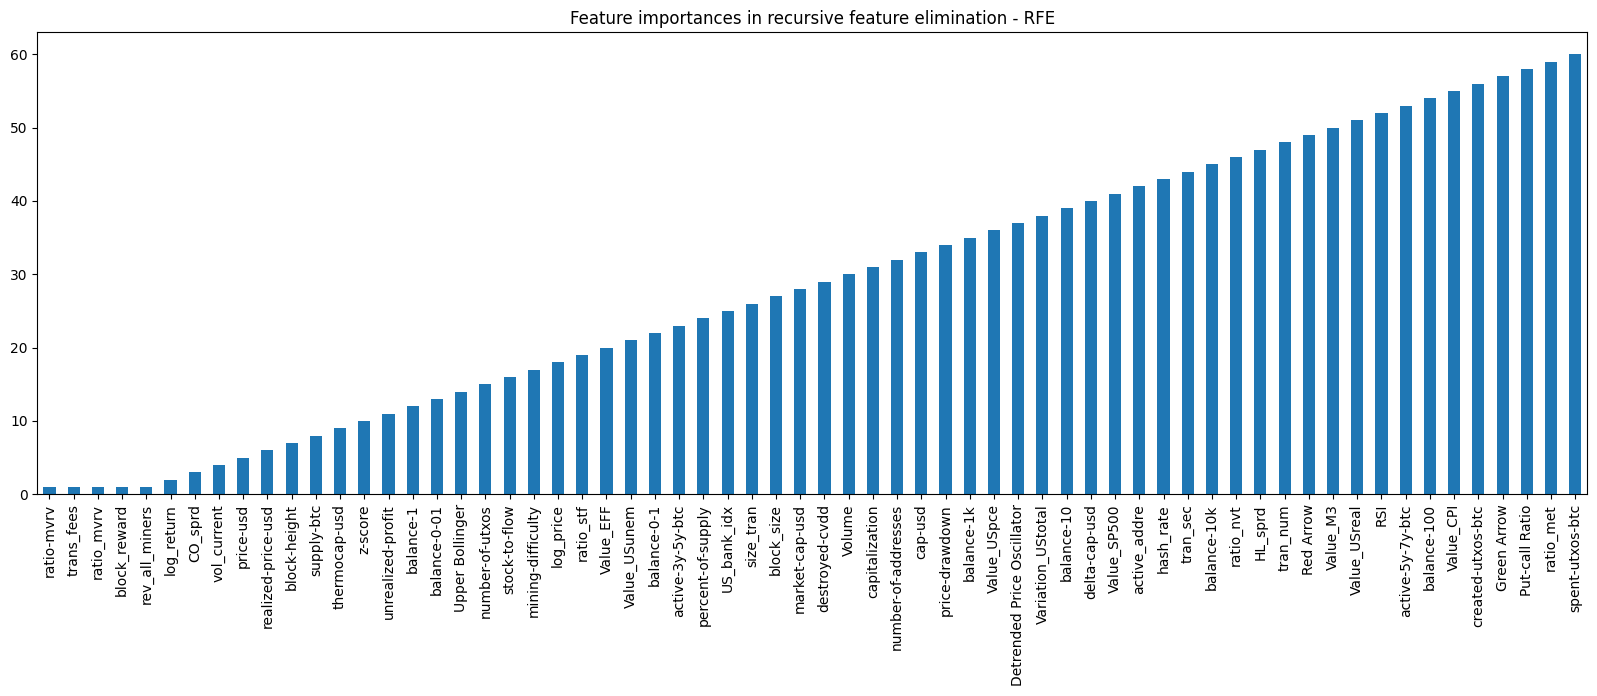

In [78]:
# Feature importances plot
importances = selector.ranking_
sorted_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(20,6))
sorted_importances.plot.bar()
plt.title("Feature importances in recursive feature elimination - RFE")
plt.show()

In [79]:
list(sorted_importances.index)

['ratio-mvrv',
 'trans_fees',
 'ratio_mvrv',
 'block_reward',
 'rev_all_miners',
 'log_return',
 'CO_sprd',
 'vol_current',
 'price-usd',
 'realized-price-usd',
 'block-height',
 'supply-btc',
 'thermocap-usd',
 'z-score',
 'unrealized-profit',
 'balance-1',
 'balance-0-01',
 'Upper Bollinger',
 'number-of-utxos',
 'stock-to-flow',
 'mining-difficulty',
 'log_price',
 'ratio_stf',
 'Value_EFF',
 'Value_USunem',
 'balance-0-1',
 'active-3y-5y-btc',
 'percent-of-supply',
 'US_bank_idx',
 'size_tran',
 'block_size',
 'market-cap-usd',
 'destroyed-cvdd',
 'Volume',
 'capitalization',
 'number-of-addresses',
 'cap-usd',
 'price-drawdown',
 'balance-1k',
 'Value_USpce',
 'Detrended Price Oscillator',
 'Variation_UStotal',
 'balance-10',
 'delta-cap-usd',
 'Value_SP500',
 'active_addre',
 'hash_rate',
 'tran_sec',
 'balance-10k',
 'ratio_nvt',
 'HL_sprd',
 'tran_num',
 'Red Arrow',
 'Value_M3',
 'Value_USreal',
 'RSI',
 'active-5y-7y-btc',
 'balance-100',
 'Value_CPI',
 'created-utxos-btc',
 

In [80]:
# Feature importance RFE with linear regression
model = DecisionTreeRegressor()
selector = RFE(model, n_features_to_select=5, step=1)
selector = selector.fit(x_transf, y)

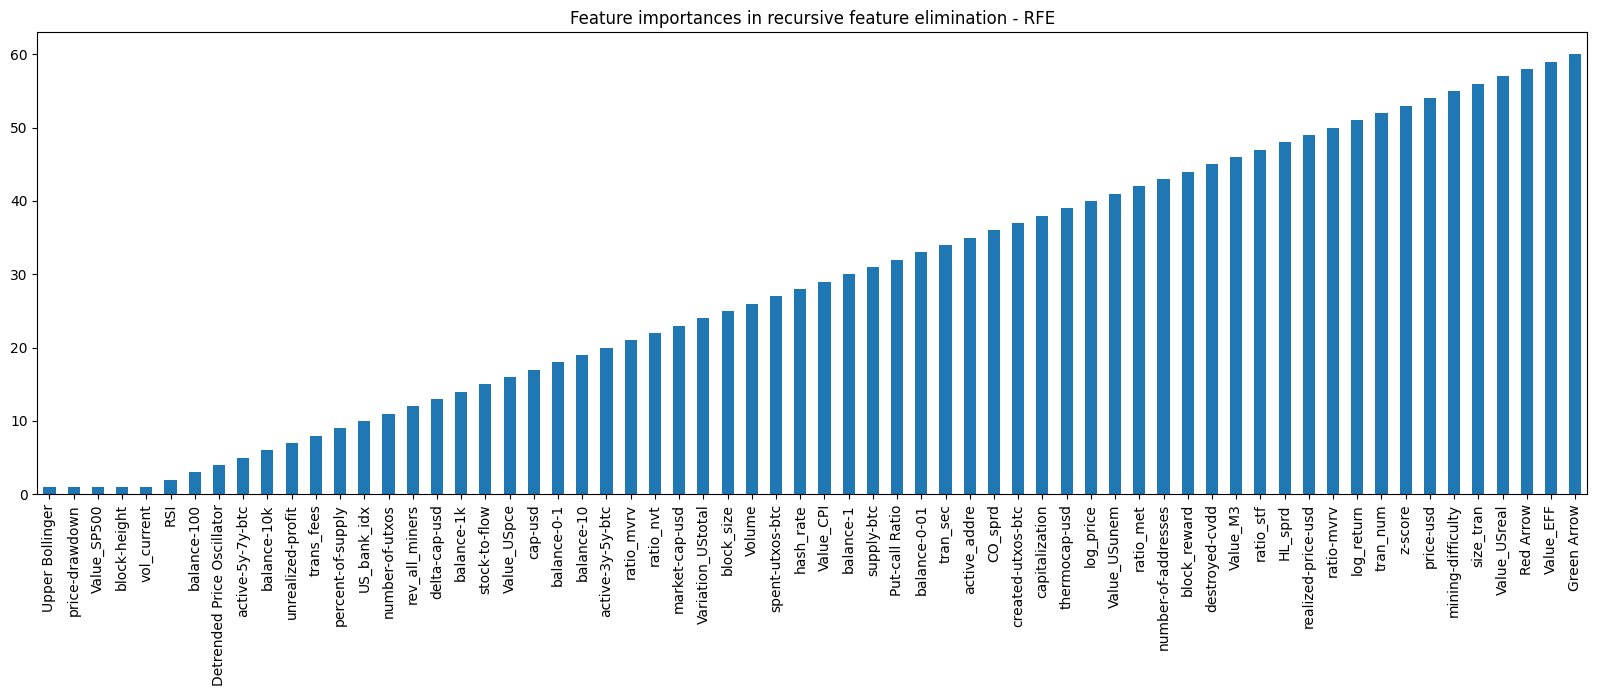

In [81]:
# Feature importances plot
importances = selector.ranking_
sorted_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(20,6))
sorted_importances.plot.bar()
plt.title("Feature importances in recursive feature elimination - RFE")
plt.show()

In [83]:
selected_features = [
'vol_current',
 'HL_sprd',
 'log_return',
 'trans_fees',
 'realized-price-usd',
 'Volume',
 'Detrended Price Oscillator',
 'price-usd',
 'balance-100',
 'ratio_mvrv',
 'US_bank_idx',
 'block_reward',
 'rev_all_miners',
 'CO_sprd'
]

# Cross-val con varios modelos

In [226]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

seed = 42

models = []
models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor(random_state=seed, n_jobs = -1)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('XGB', xgb(random_state=seed)))
#models.append(('LGBM', LGBMRegressor(random_state=seed)))
models.append(('CATBOOST', CatBoostRegressor(random_state=seed)))

metrics = []
metrics.append(('RMSE','neg_root_mean_squared_error'))

In [227]:
""" Para plotear los resultados utilizaremos la siguiente función """
def boxplots_algorithms(results, names, metric):
        
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.title(metric)
    plt.show()

LR: -0.118288 (0.181966)
DTR: -0.013347 (0.003771)
KNR: -0.019830 (0.005391)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks

RFR: -0.010381 (0.004510)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:43

GBR: -0.010239 (0.004354)
XGB: -0.010976 (0.003263)
Learning rate set to 0.039838
Learning rate set to 0.042471
Learning rate set to 0.044445
Learning rate set to 0.035712
Learning rate set to 0.046039
0:	learn: 0.0129584	total: 59.4ms	remaining: 59.4s
0:	learn: 0.0167664	total: 59.8ms	remaining: 59.7s
0:	learn: 0.0181906	total: 59.9ms	remaining: 59.8s
0:	learn: 0.0177716	total: 60.3ms	remaining: 1m
0:	learn: 0.0164944	total: 59.5ms	remaining: 59.4s
1:	learn: 0.0162404	total: 62.4ms	remaining: 31.1s
1:	learn: 0.0176511	total: 62.5ms	remaining: 31.2s
1:	learn: 0.0172639	total: 63.2ms	remaining: 31.5s
1:	learn: 0.0126324	total: 63.2ms	remaining: 31.5s
1:	learn: 0.0159471	total: 63ms	remaining: 31.4s
2:	learn: 0.0170970	total: 65.3ms	remaining: 21.7s
2:	learn: 0.0157272	total: 65.7ms	remaining: 21.8s
2:	learn: 0.0123022	total: 65.5ms	remaining: 21.8s
2:	learn: 0.0154108	total: 65.9ms	remaining: 21.9s
2:	learn: 0.0167116	total: 67.1ms	remaining: 22.3s
3:	learn: 0.0166067	total: 67.6ms	rema

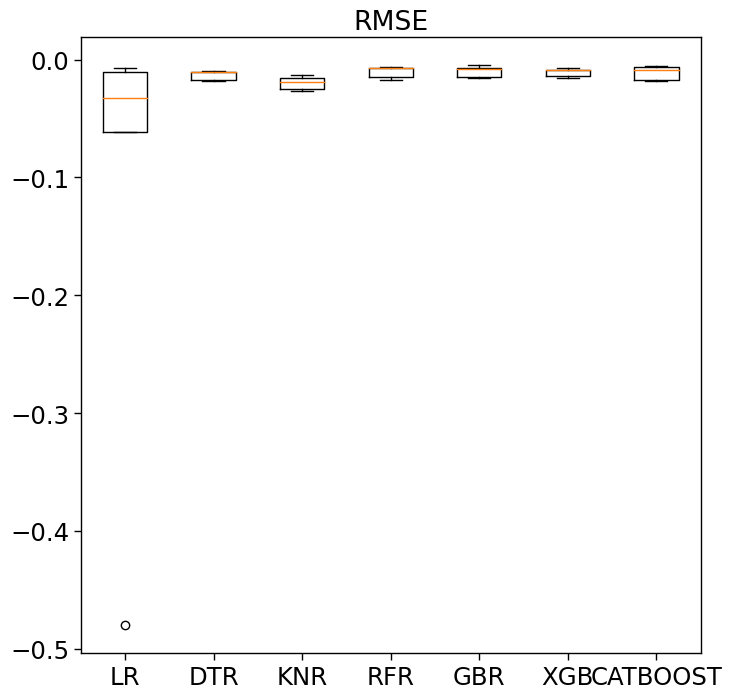

In [228]:
from sklearn.model_selection import TimeSeriesSplit


for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        cv_technique = TimeSeriesSplit()
        cv_results = cross_val_score(model,                 # Pipeline
                                     X[selected_features],  # Feature matrix
                                     y,                     # Target vector
                                     cv=cv_technique,       # Cross-validation technique
                                     scoring=scoring,       # Scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric)

# Modeling

### Results:

In [91]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

## Xgboost

In [200]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix, recall_score, precision_score
from xgboost import plot_importance

In [201]:
# define model
xg = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xg, X[selected_features], y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.5f (%.5f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.00270 (0.00023)


In [202]:
xg.fit(x_train[selected_features], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [203]:
# make a prediction
y_pred_xg = xg.predict(x_val[selected_features])

In [204]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

# calculate manually
d = y_val['vol_future'] - y_pred_xg

mse_f = mean_squared_error(y_val['vol_future'], y_pred_xg)
rmse_f = np.sqrt(mse_f)
r2_f = r2_score(y_val['vol_future'], y_pred_xg)

print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MSE: 5.259436836884386e-05
RMSE: 0.007252197485510434
R-Squared: 0.49850474297075964


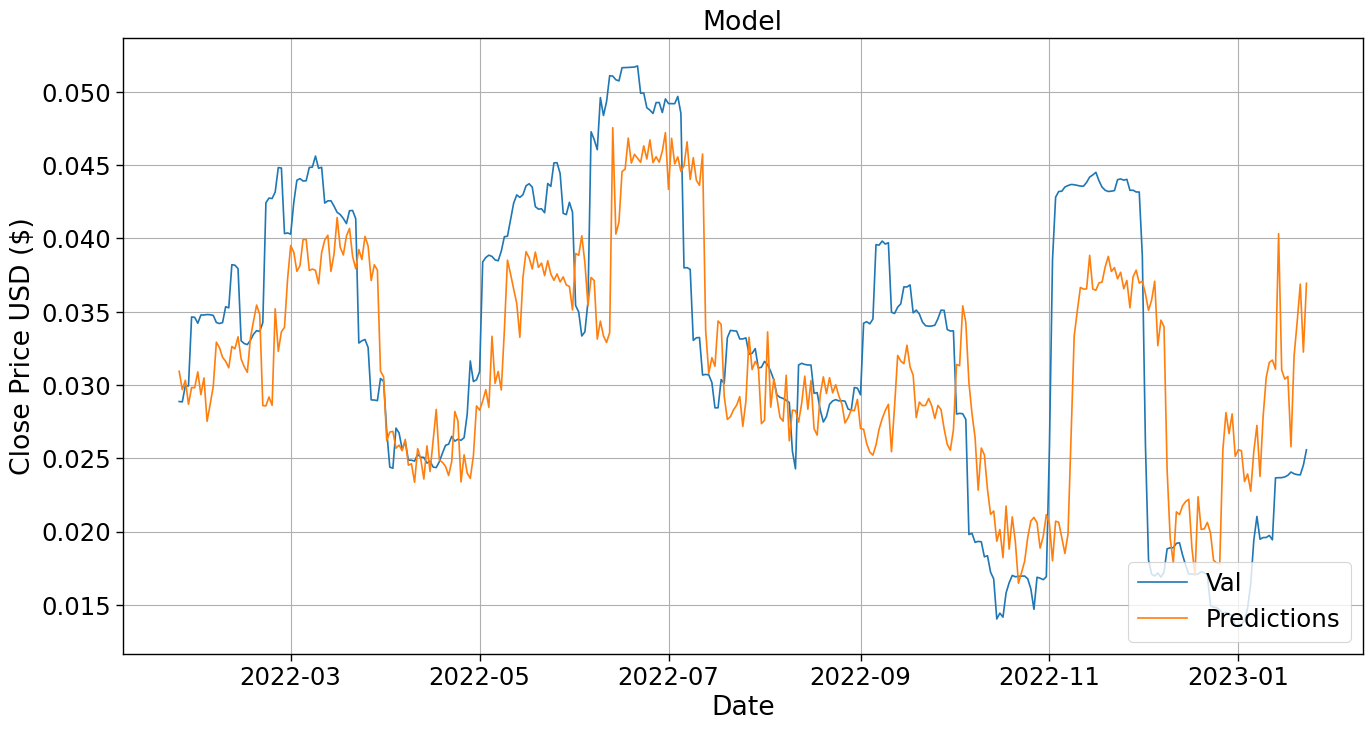

In [205]:
# dic = {'vol_future': y_val_scaled}
# validation = pd.DataFrame(dic)

validation = y_val
validation['Predictions'] = y_pred_xg
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')

plt.ylabel('Close Price USD ($)')
#plt.plot(train)

plt.plot(validation[['vol_future', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [206]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
um.log_perf(y_val['vol_future'], y_pred_xg,
        "xgboost", perf_df=perf_df)

Model  Validation RMSPE  Validation RMSE
0  xgboost          0.274826         0.007252

## Catboost

In [207]:
# define model
cb = CatBoostRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(cb, X[selected_features], y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

cb.fit(x_train[selected_features], y_train)

Learning rate set to 0.046602
Learning rate set to 0.046602
Learning rate set to 0.046602
Learning rate set to 0.046598
Learning rate set to 0.046602
Learning rate set to 0.046602
Learning rate set to 0.046602
0:	learn: 0.0158055	total: 57ms	remaining: 56.9s
0:	learn: 0.0157493	total: 59.2ms	remaining: 59.2s
1:	learn: 0.0153058	total: 58.8ms	remaining: 29.3s
0:	learn: 0.0154780	total: 58ms	remaining: 57.9s
1:	learn: 0.0152352	total: 61.8ms	remaining: 30.9s
2:	learn: 0.0148031	total: 61.2ms	remaining: 20.3s
2:	learn: 0.0147462	total: 63.7ms	remaining: 21.2s
1:	learn: 0.0149801	total: 60.2ms	remaining: 30s
3:	learn: 0.0143428	total: 63.4ms	remaining: 15.8s
3:	learn: 0.0142676	total: 65.8ms	remaining: 16.4s
2:	learn: 0.0145030	total: 62.6ms	remaining: 20.8s
4:	learn: 0.0138851	total: 66.1ms	remaining: 13.2s
4:	learn: 0.0138257	total: 68ms	remaining: 13.5s
3:	learn: 0.0140567	total: 65.4ms	remaining: 16.3s
5:	learn: 0.0134891	total: 68.7ms	remaining: 11.4s
5:	learn: 0.0134121	total: 70.6ms

In [208]:
# make a predictionç
y_pred_cat = cb.predict(x_val[selected_features])

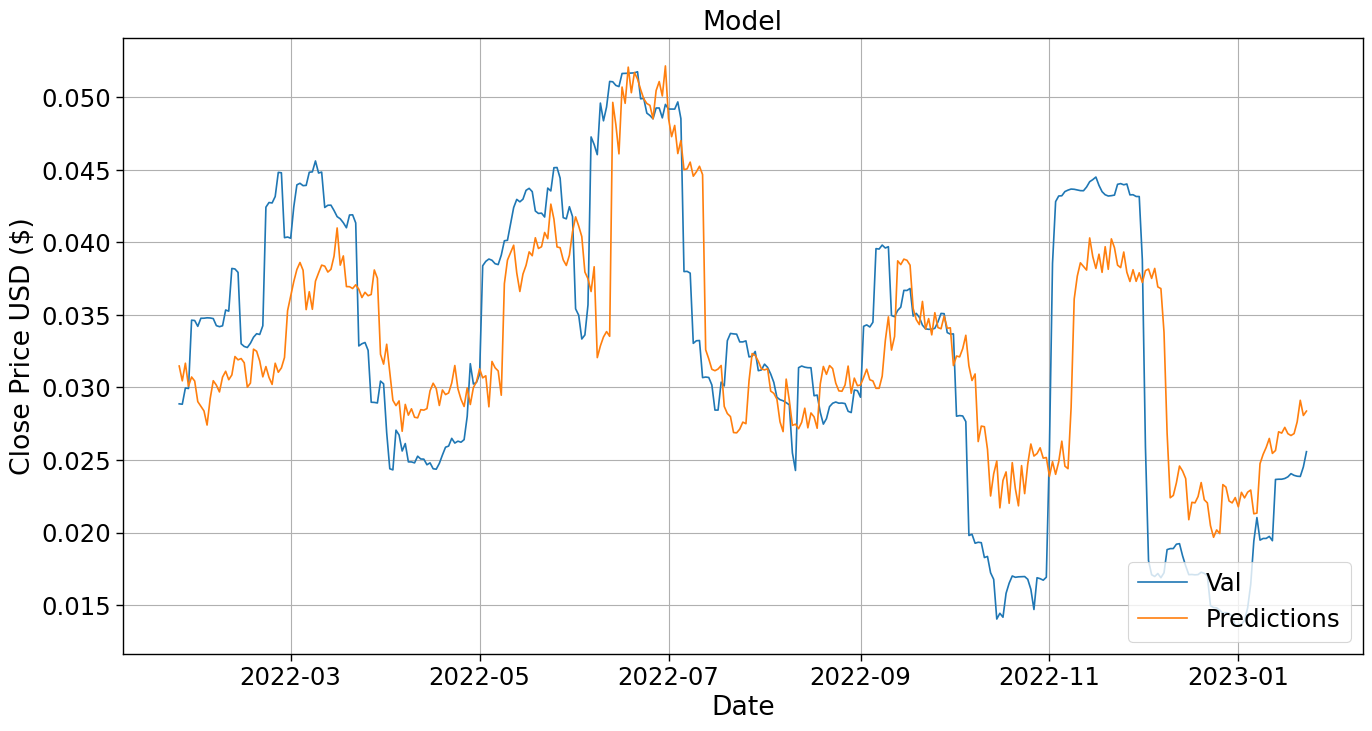

In [209]:
validation = y_val
validation['Predictions'] = y_pred_cat
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')

plt.ylabel('Close Price USD ($)')
#plt.plot(train)

plt.plot(validation[['vol_future', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [210]:
# append metrics to perf_df 
um.log_perf(y_val['vol_future'], y_pred_cat,
        "catboost", perf_df=perf_df)

Model  Validation RMSPE  Validation RMSE
0   xgboost          0.274826         0.007252
1  catboost          0.272257         0.006551

## LSTM

In [85]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [55]:
#SUBDATASETS



#best
features_0 = ['vol_current',
 'HL_sprd',
 'log_return', 'trans_fees']


#sale mejor sin log
features_1 = ['vol_current',
 'HL_sprd',
 'returns', 'trans_fees']


#2nd
features_2 = [
'returns',
'unrealized-profit',
'vol_current',
'HL_sprd'
]


#2nd
features_3 = [
'ratio_mvrv',
'vol_current',
'HL_sprd',
'returns'
]


roy = ['vol_current', 'ratio_mvrv', 'HL_sprd', 'trans_fees']
      # 'Volume']

list_feat = [features_1, features_2, features_3]



In [92]:
#RANDOM SELECTED FEATURES
seed=1234
import itertools

# Define the range of group sizes to consider
group_sizes = [3,4,5]
i=0
# Iterate over different group sizes
for size in group_sizes:
    # Generate all possible combinations of features for the current group size
    feature_combinations = list(itertools.combinations(selected_features, size))
    
    # Iterate over each combination
    for combination in feature_combinations:
        i+=1
            # SEPARATE INPUT DATAFRAME FROM df
        input_df = df[list(combination)]

        # SEPARATE INPUTS FOR TRAINING SET ONLY
        X_train = input_df.loc[train_idx]

        tf.keras.backend.clear_session()

        # Seed for reproducibility
        np.random.seed(seed)

        n_past = 30
        batch_size = 64
        n_dims = input_df.shape[1]

        mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

        # CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
        lstm_2 = tf.keras.models.Sequential([ 
            tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
            # BATCH NORMALIZATION
            tf.keras.layers.BatchNormalization(), 

            # ADDING 1st LSTM LAYER
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Dropout(0.1),


            # ADDING 3nd LSTM LAYER
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
            tf.keras.layers.Dropout(0.1),

            # DENSE OUTPUT LAYER
            tf.keras.layers.Dense(1)
        ])

        lstm_2.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[um.rmspe])


        # stopping the training if validation rmspe is not improving    
        early_stopping_cb = EarlyStopping(patience=30,
                                        restore_best_weights=True,
                                        monitor='val_rmspe')
        
            #saving model
        checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')


            # fitting training data
        lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                    validation_split=0.2, shuffle=True,
                                verbose=0, batch_size=batch_size, epochs=200)


        # forecasting on validation set
        lstm_2_preds = um.forecast_multi(lstm_2, val_idx, input_df=input_df, df=df, n_past=n_past)

        ## append metrics to perf_df 
        um.log_perf(y_val['vol_future'], lstm_2_preds,
            f"lstm 2 layers {combination}", perf_df=perf_df)

              
        # Example: Printing the current combination
        print("Testing combination:", combination)
        



print(i)

2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'log_return')
2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'trans_fees')
2022-01-24 00:00:00
12/12 [==============================] - 1s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'realized-price-usd')
2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'Volume')
2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'Detrended Price Oscillator')
2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'price-usd')
2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step
Testing combination: ('vol_current', 'HL_sprd', 'balance-100')
2022-01-24 00:00:00
12/12 [========

KeyboardInterrupt: 

In [94]:
perf_df.sort_values('Validation RMSPE').to_csv('combinations_results.csv', index=False)

### BI-LSTM 2 Layers

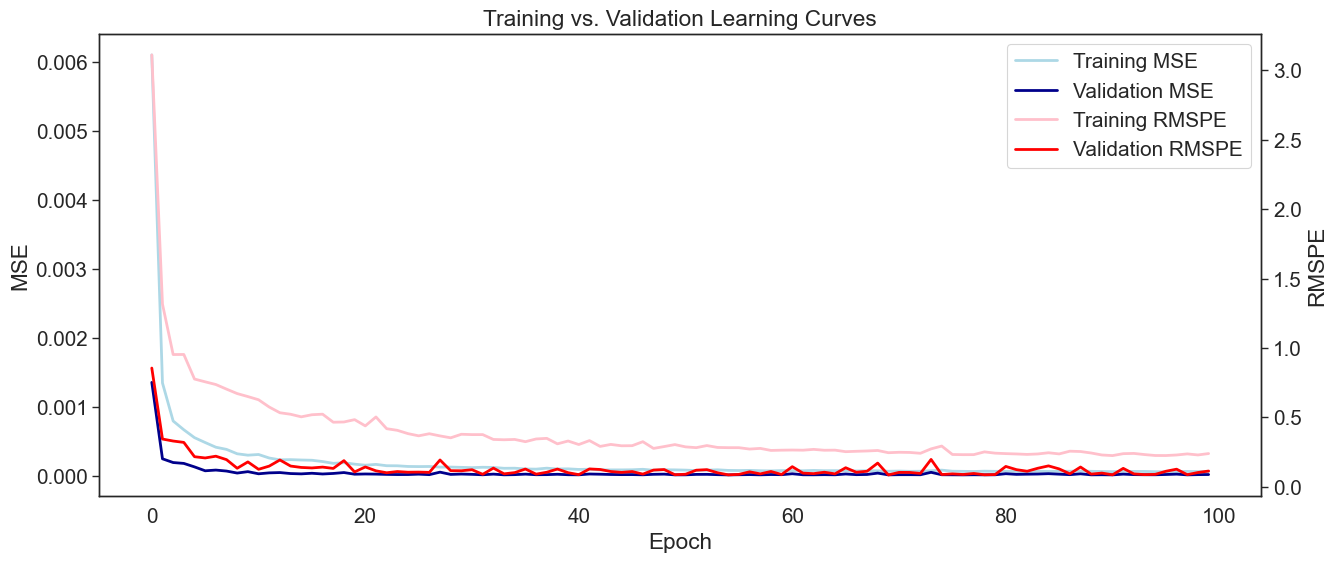

2022-01-24 00:00:00
12/12 [==============================] - 0s 2ms/step


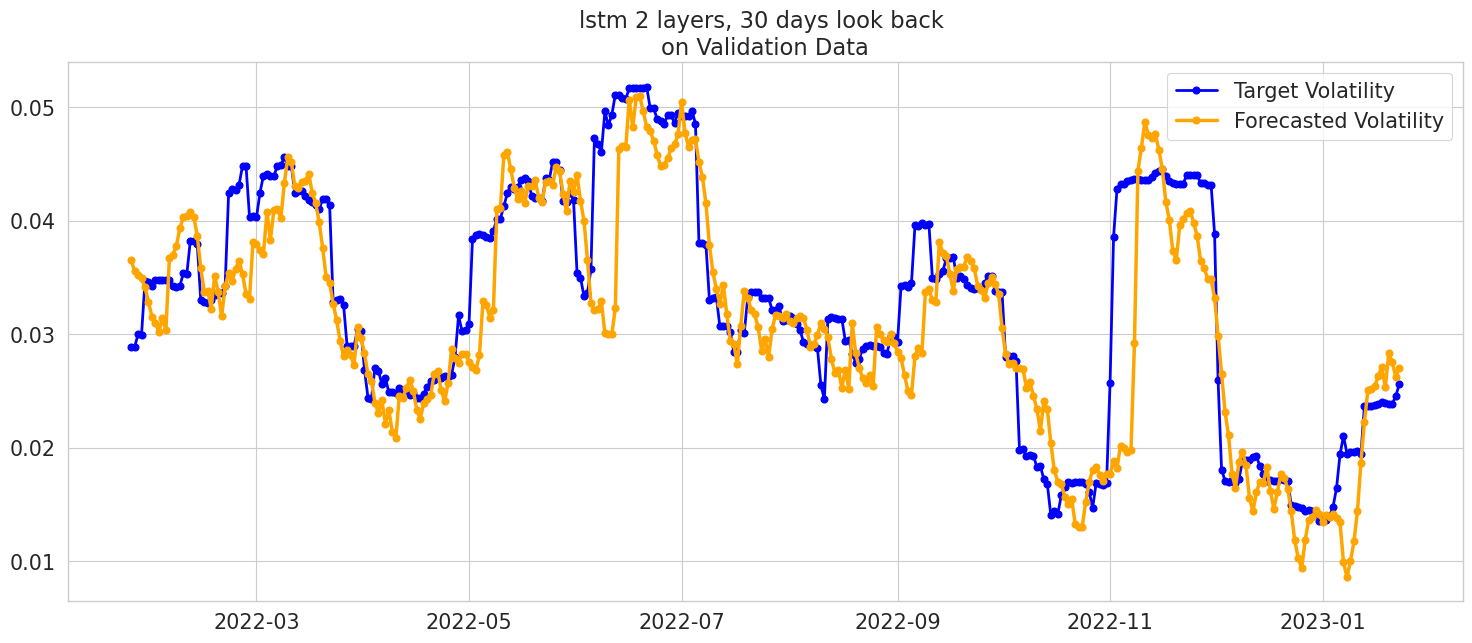

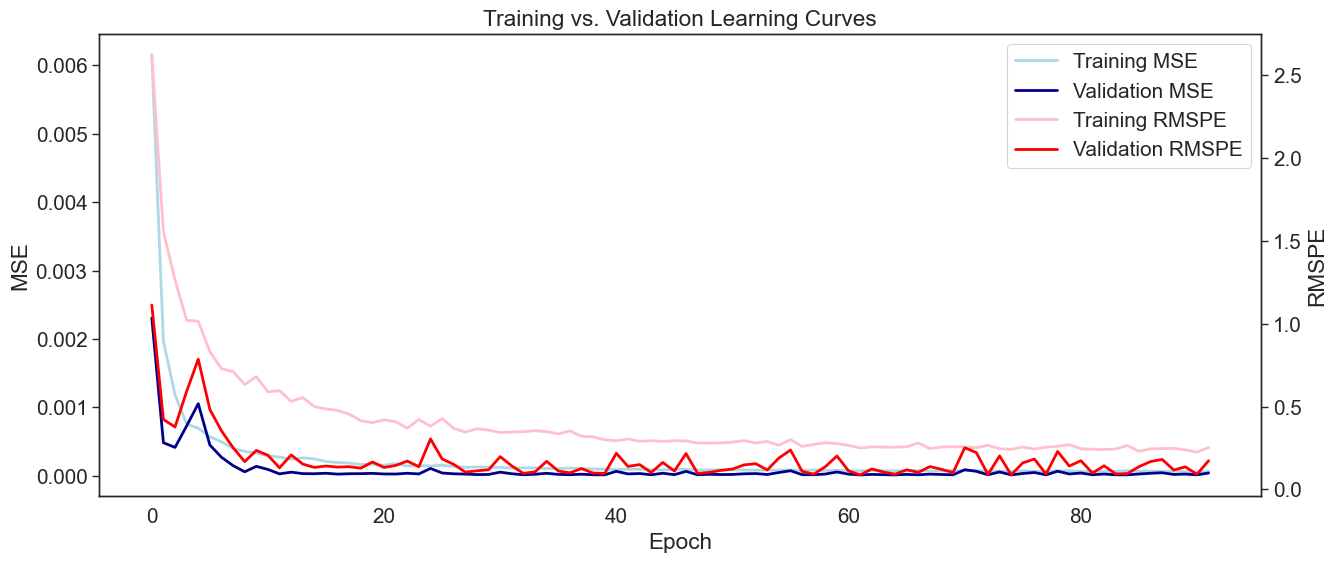

2022-01-24 00:00:00
12/12 [==============================] - 0s 3ms/step


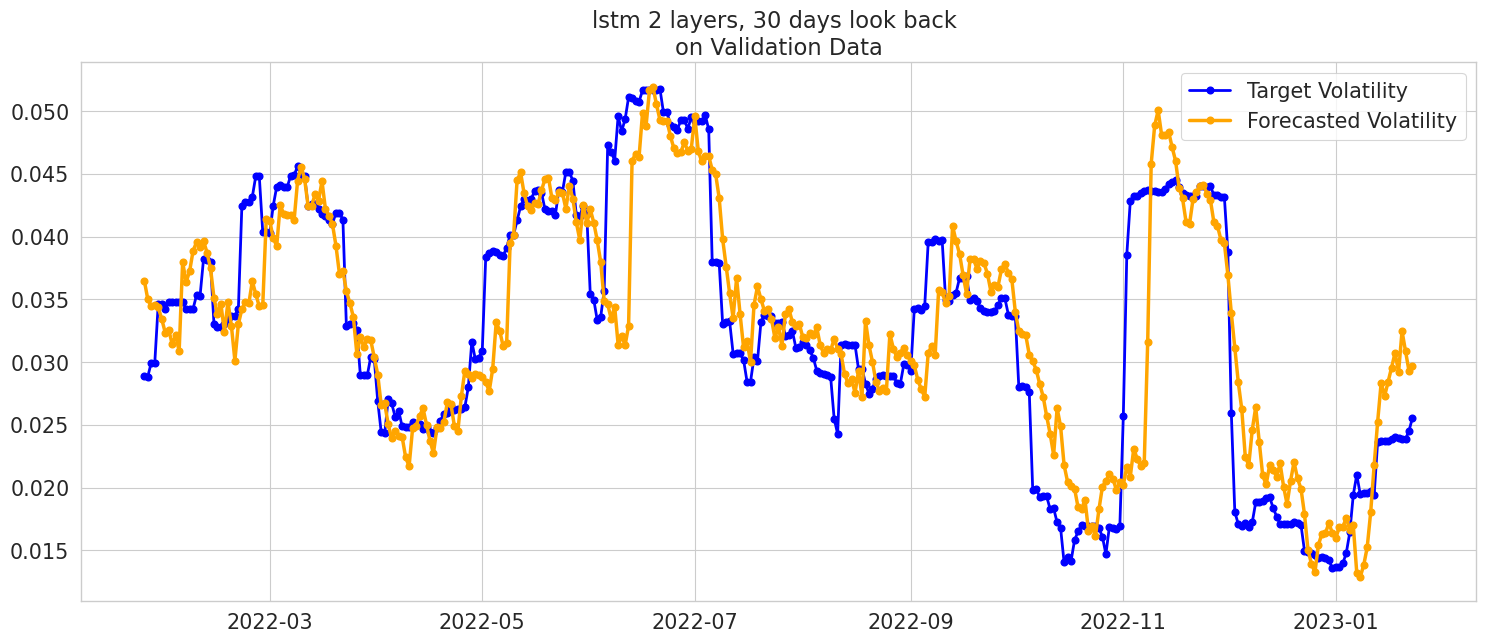

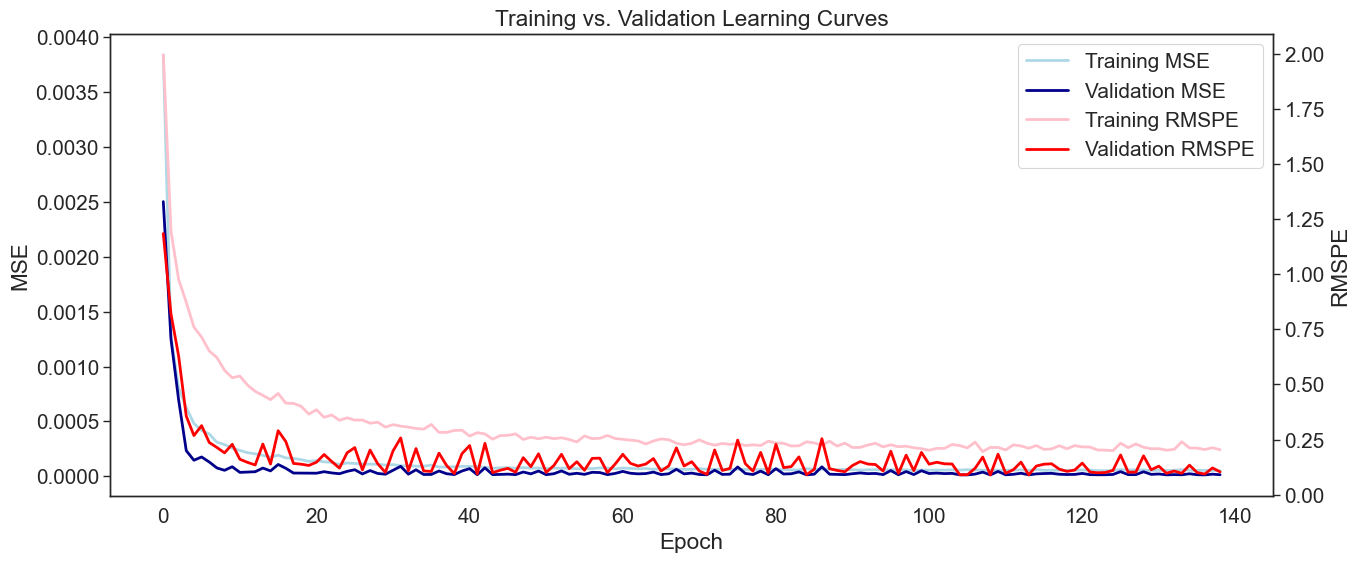

2022-01-24 00:00:00
12/12 [==============================] - 1s 2ms/step


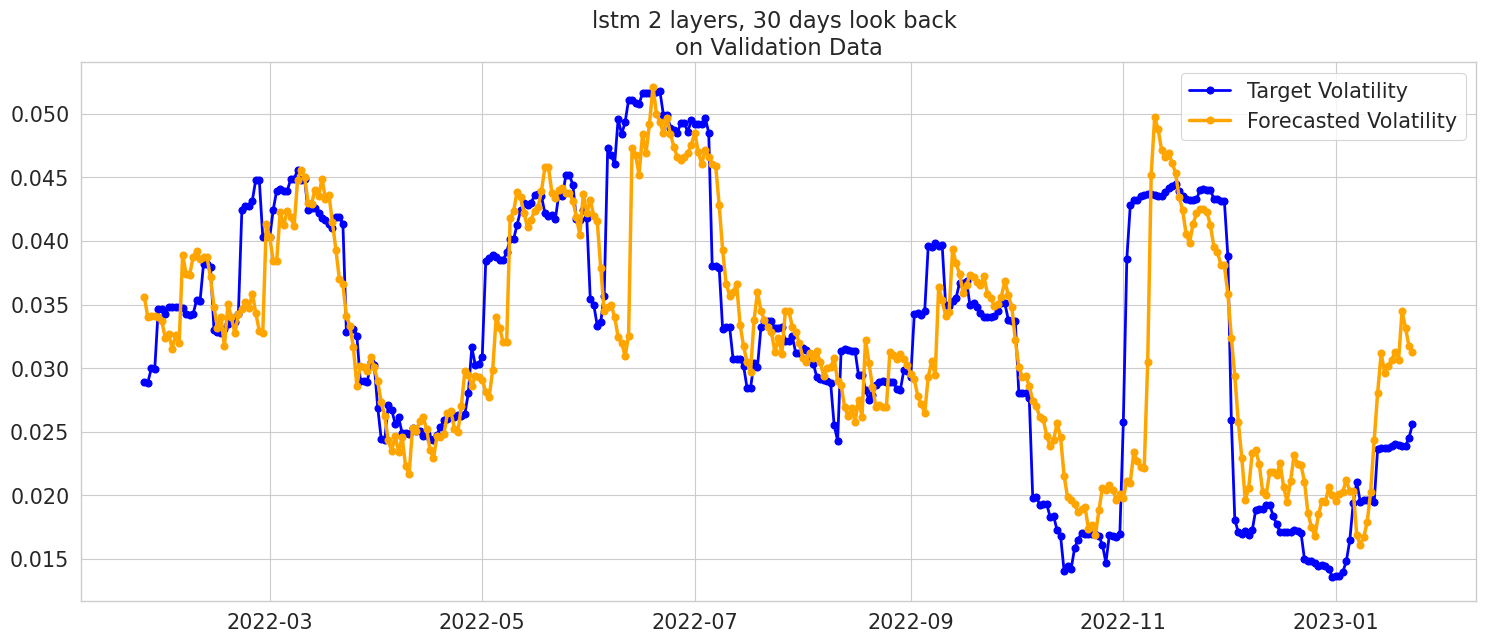

In [56]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 
    
    # SEPARATE INPUT DATAFRAME FROM df
    input_df = df[features]

    # SEPARATE INPUTS FOR TRAINING SET ONLY
    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

    # CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
    lstm_2 = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        # BATCH NORMALIZATION
        tf.keras.layers.BatchNormalization(), 

        # ADDING 1st LSTM LAYER
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),


        # ADDING 3nd LSTM LAYER
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),

        # DENSE OUTPUT LAYER
        tf.keras.layers.Dense(1)
    ])

    lstm_2.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')



        # fitting training data
    lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_2_res)

    # forecasting on validation set
    lstm_2_preds = um.forecast_multi(lstm_2, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_2_preds_scaled = um.scale(scaler_vol, lstm_2_preds)

    # plotting predictions-target
    um.viz_model(y_val['vol_future'], lstm_2_preds, 
            f"lstm 2 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_2_preds,
         f"lstm 2 layers {i}", perf_df=perf_df)
    
    i = i+1

In [57]:
# Results
perf_df

Model  Validation RMSPE  Validation RMSE
0  lstm 2 layers 0          0.162187         0.005473
1  lstm 2 layers 1          0.176073         0.005199
2  lstm 2 layers 2          0.180498         0.005240

### BI-LSTM 3 Layers

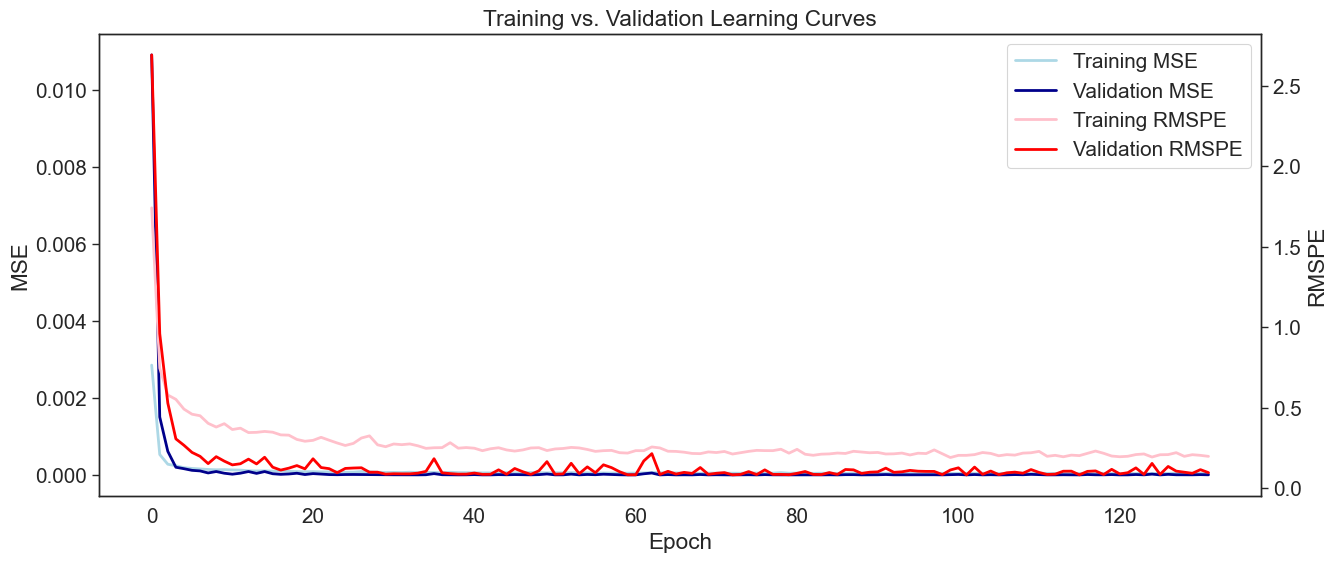

2022-01-24 00:00:00
12/12 [==============================] - 1s 4ms/step


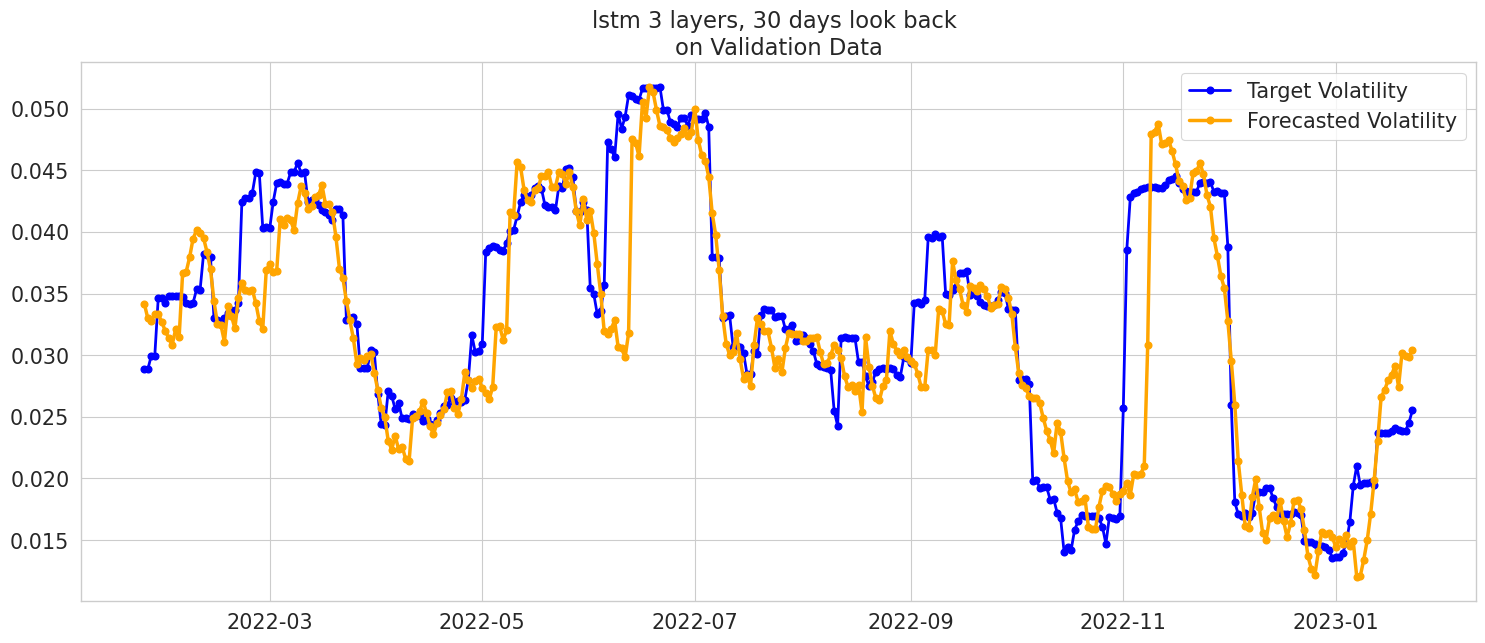

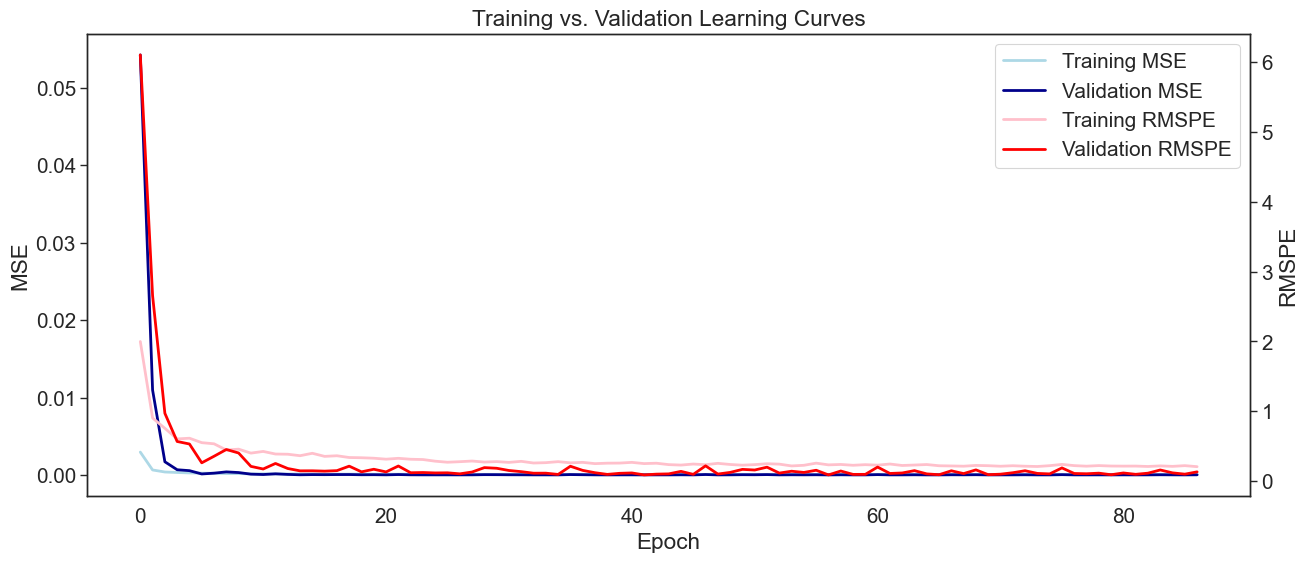

2022-01-24 00:00:00
12/12 [==============================] - 1s 4ms/step


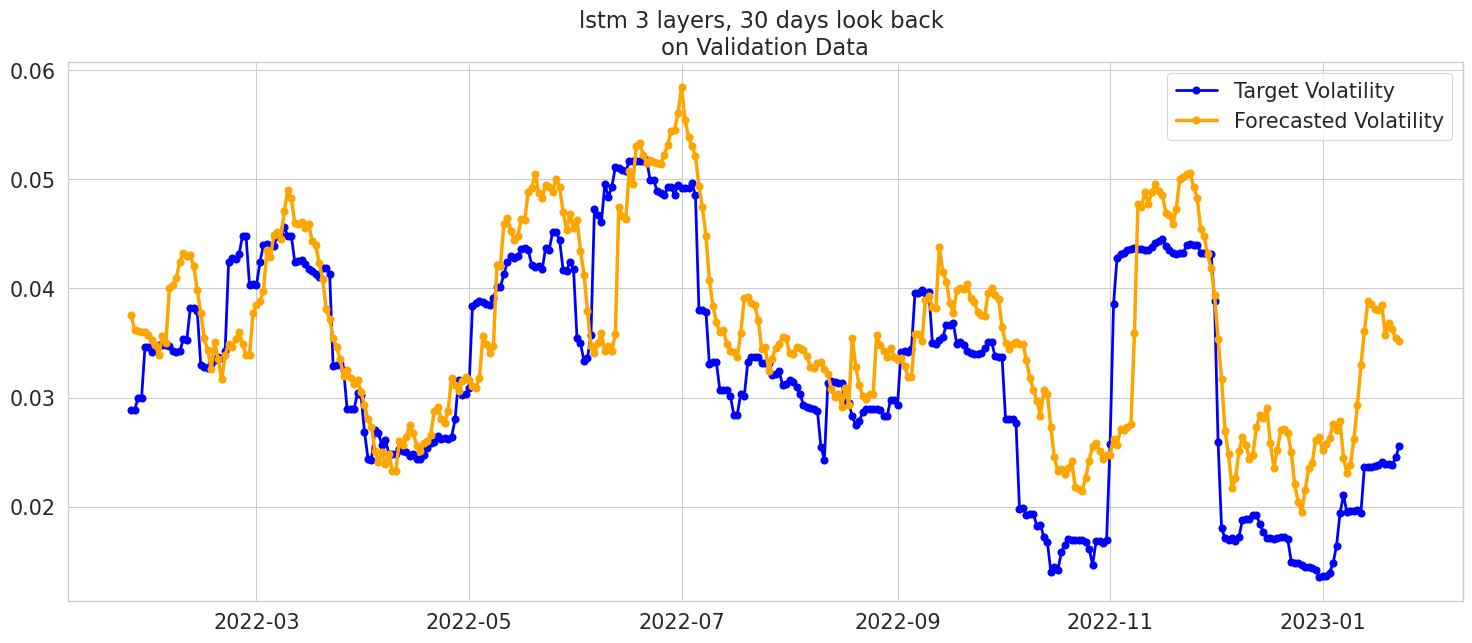

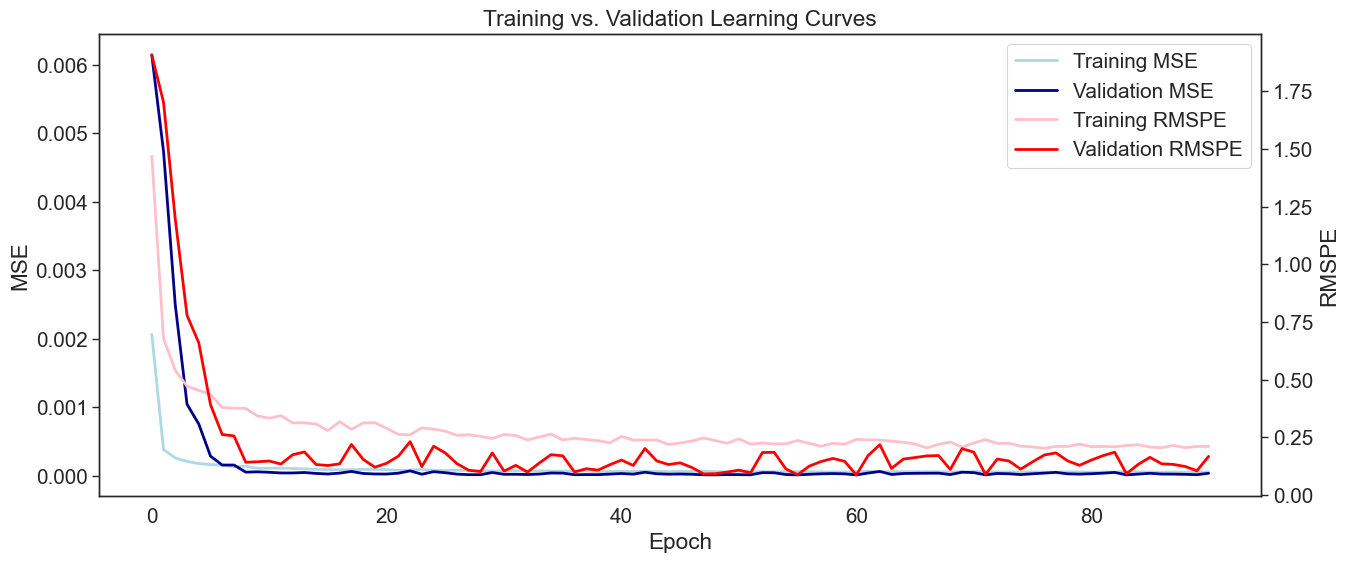

2022-01-24 00:00:00
12/12 [==============================] - 1s 4ms/step


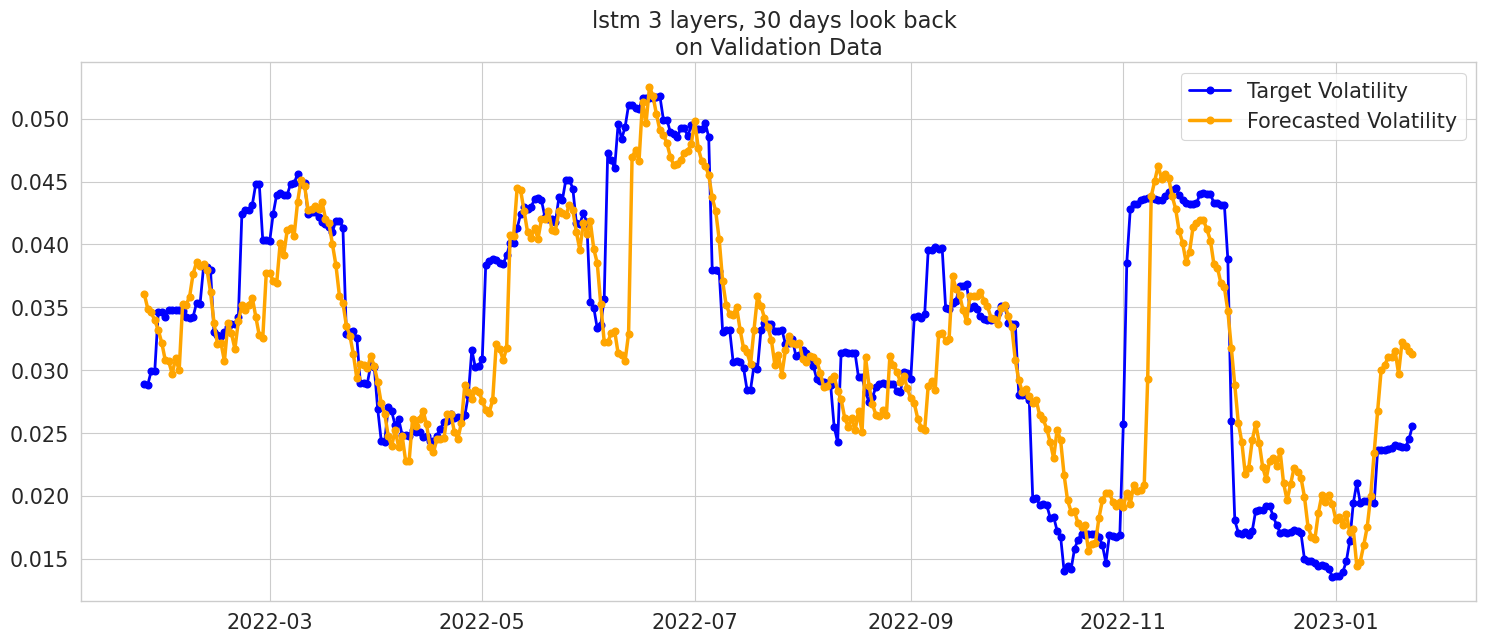

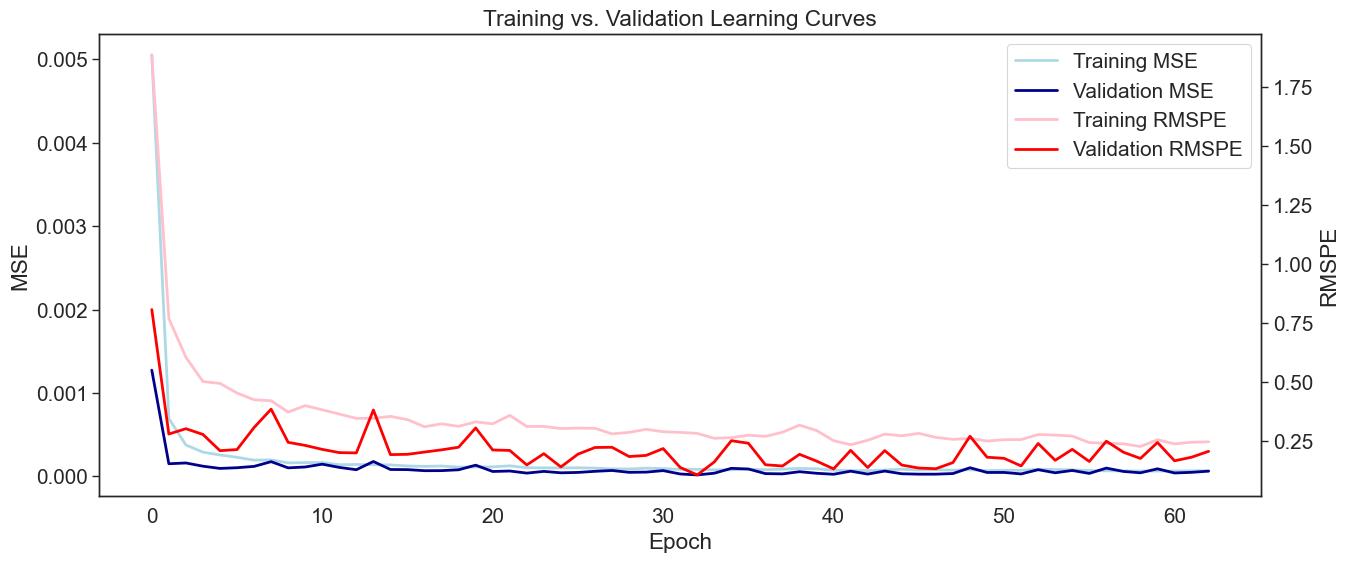

2022-01-24 00:00:00
12/12 [==============================] - 1s 4ms/step


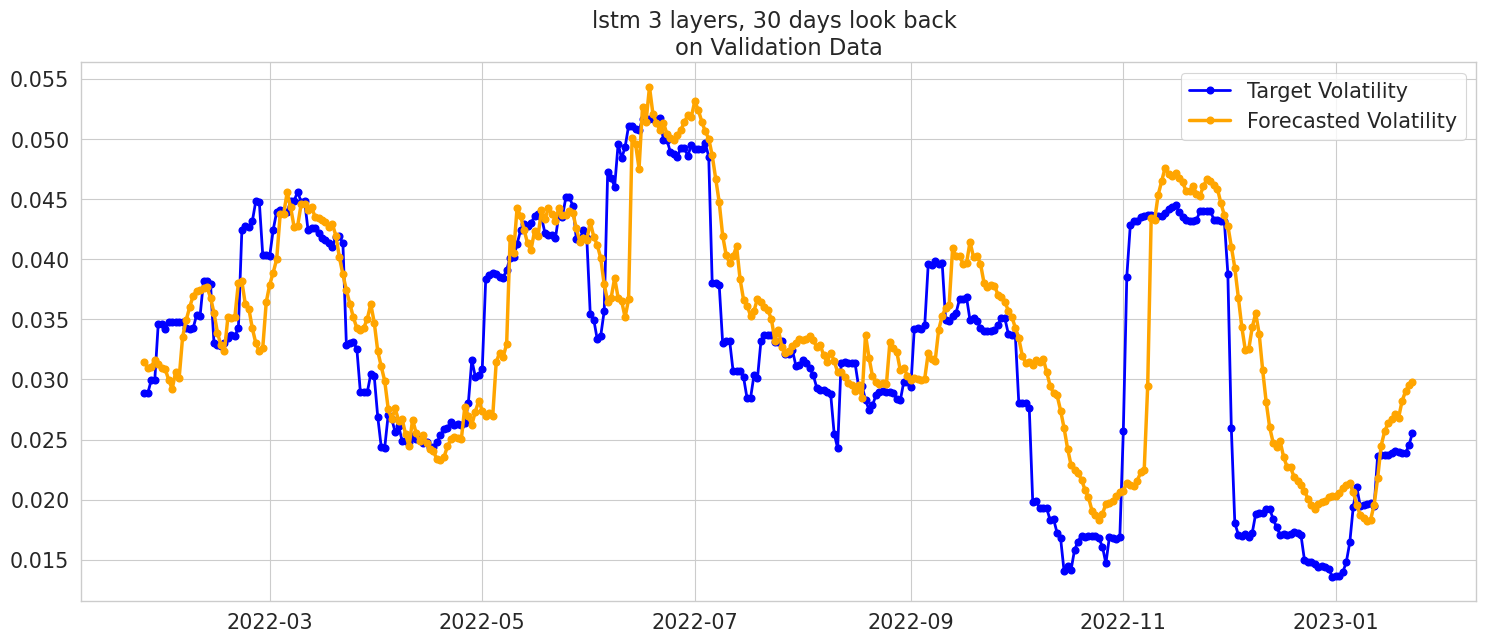

In [48]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 

    input_df = df[features]

    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

    lstm_3 = tf.keras.models.Sequential([  
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        # normalize,
   
        tf.keras.layers.BatchNormalization(), 
        
        # 3rd LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Dense(1)
    ])

    lstm_3.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')


    # fitting training data
    lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_3_res)

    # forecasting on validation set
    lstm_3_preds = um.forecast_multi(lstm_3, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_3_preds_scaled = um.scale(scaler_vol, lstm_3_preds)

    # plotting predictions-target
    um.viz_model(y_val['vol_future'], lstm_3_preds, 
            f"lstm 3 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_3_preds,
         f"lstm 3 layers {i}", perf_df=perf_df)
    
    i = i+1

In [1]:
# Results
perf_df

NameError: name 'perf_df' is not defined

### BI-LSTM 4 Layers

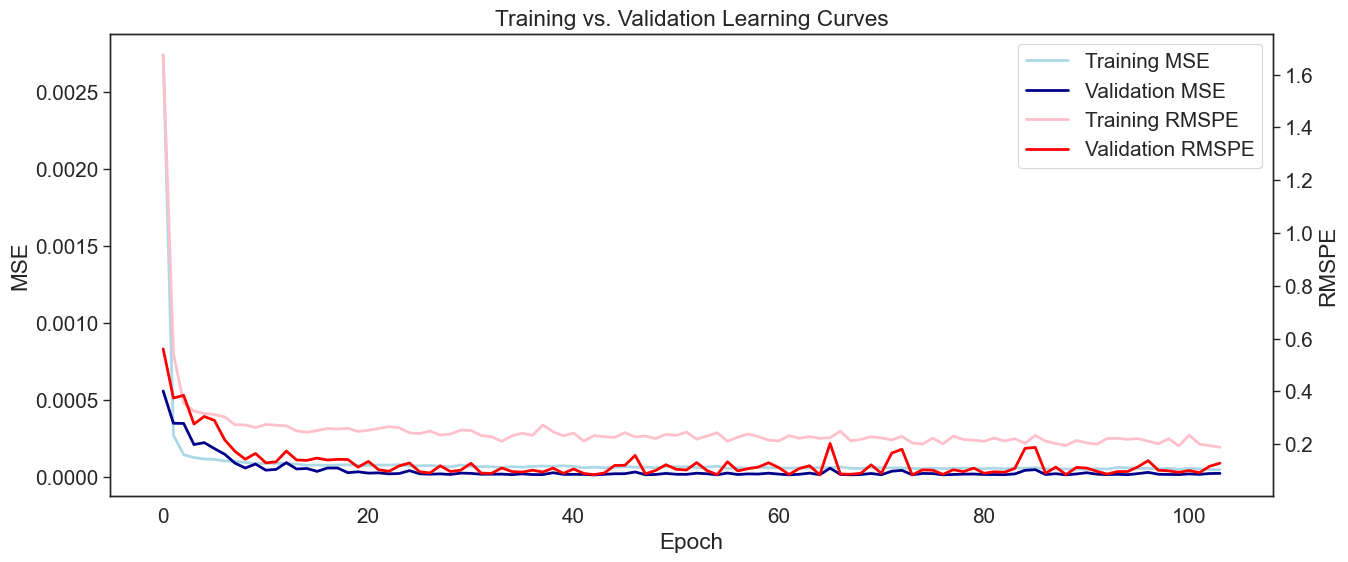

2022-01-24 00:00:00
12/12 [==============================] - 1s 9ms/step


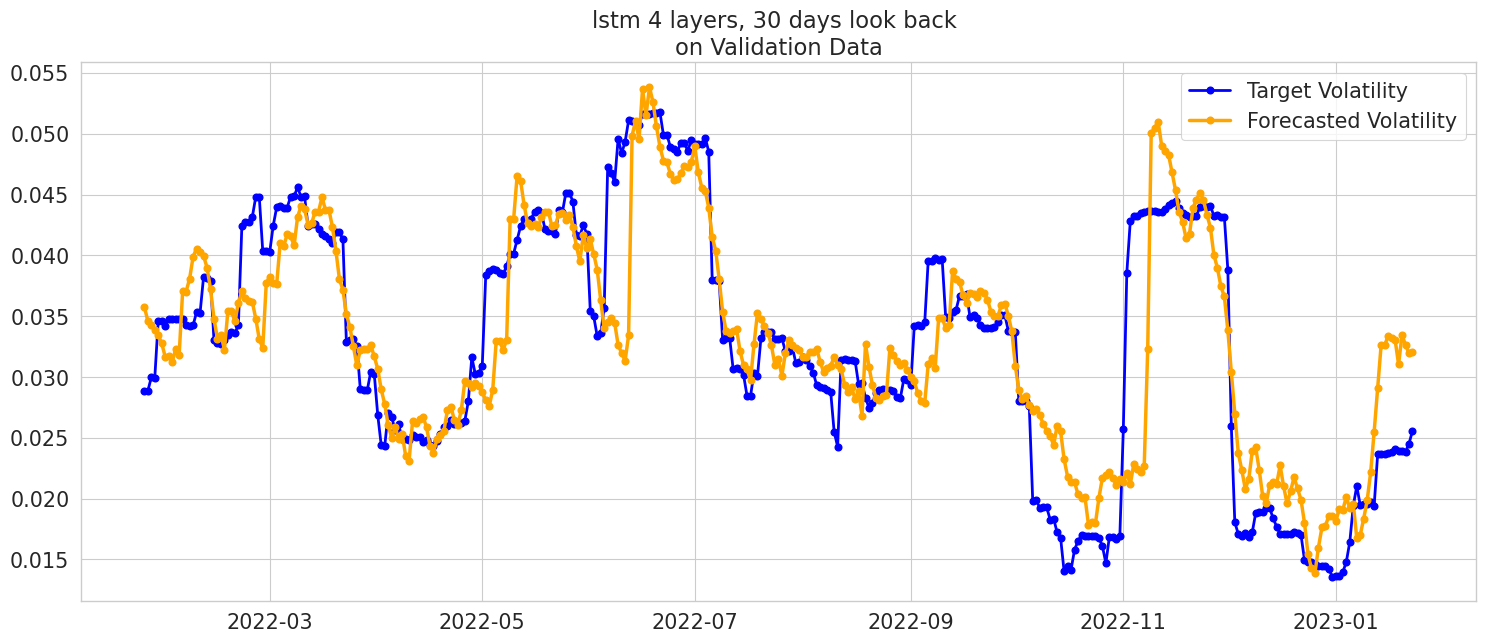

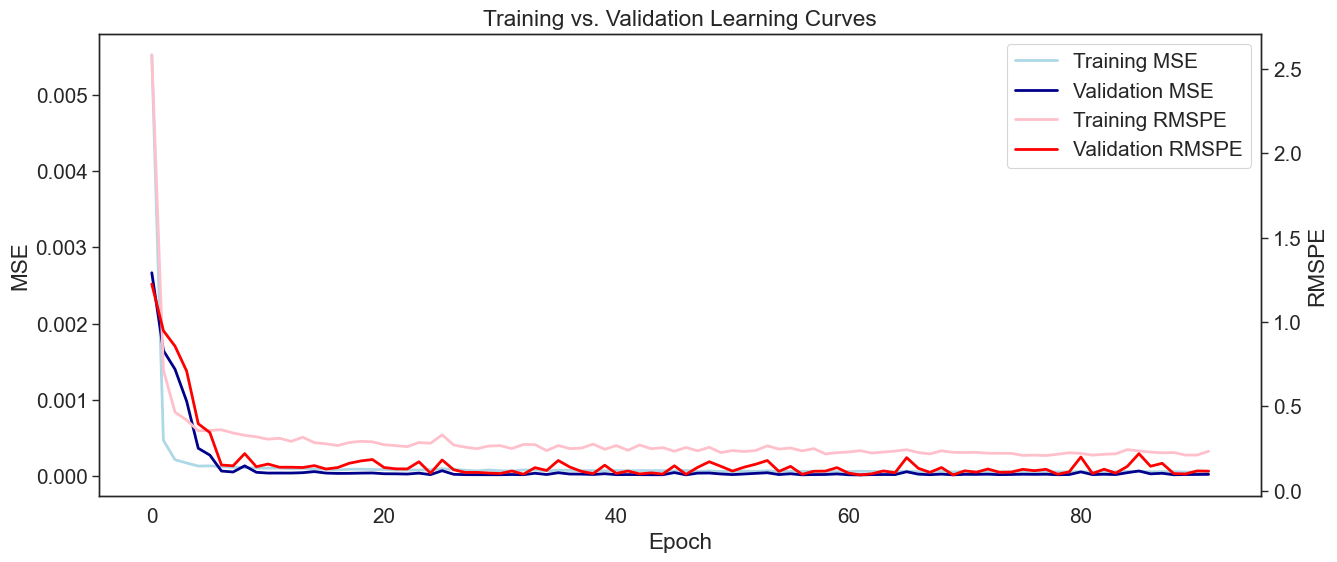

2022-01-24 00:00:00
12/12 [==============================] - 1s 8ms/step


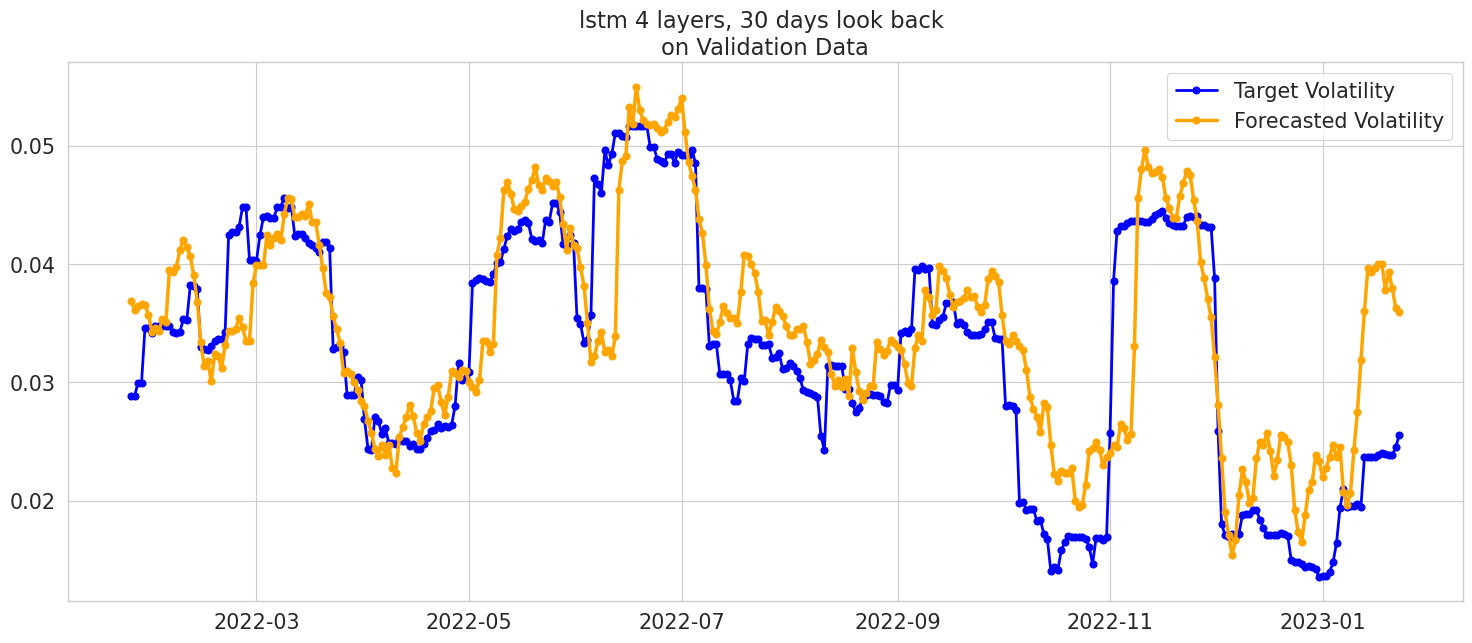

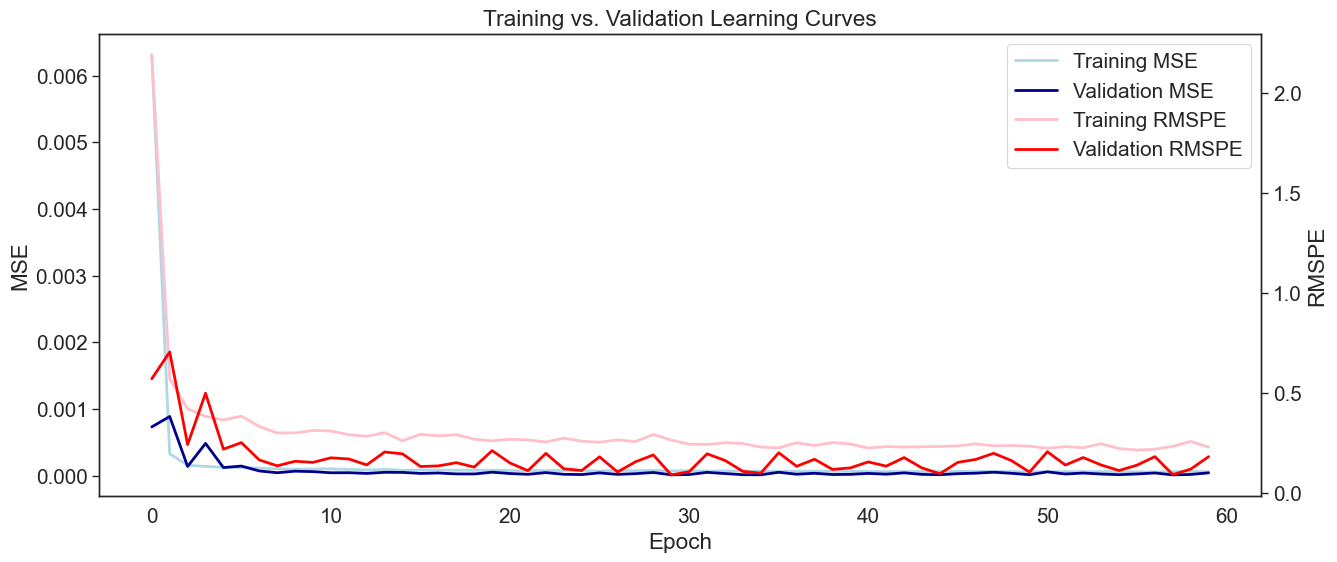

2022-01-24 00:00:00
12/12 [==============================] - 1s 9ms/step


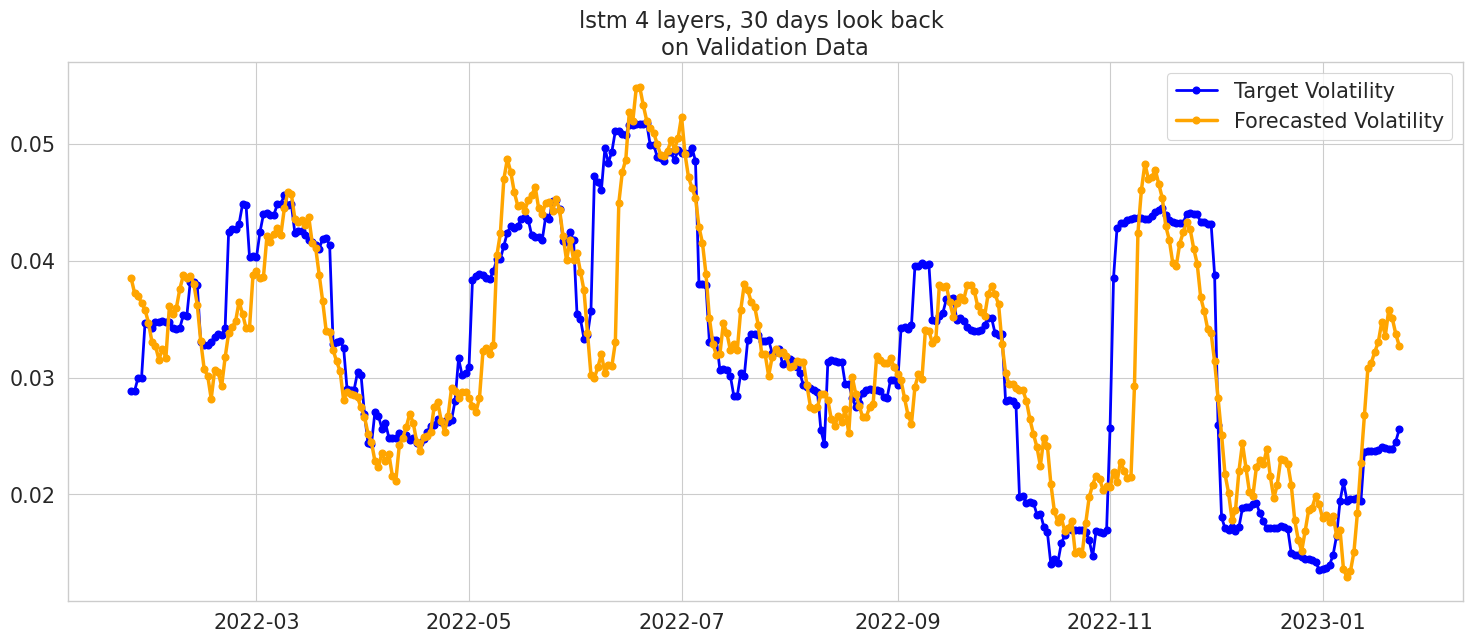

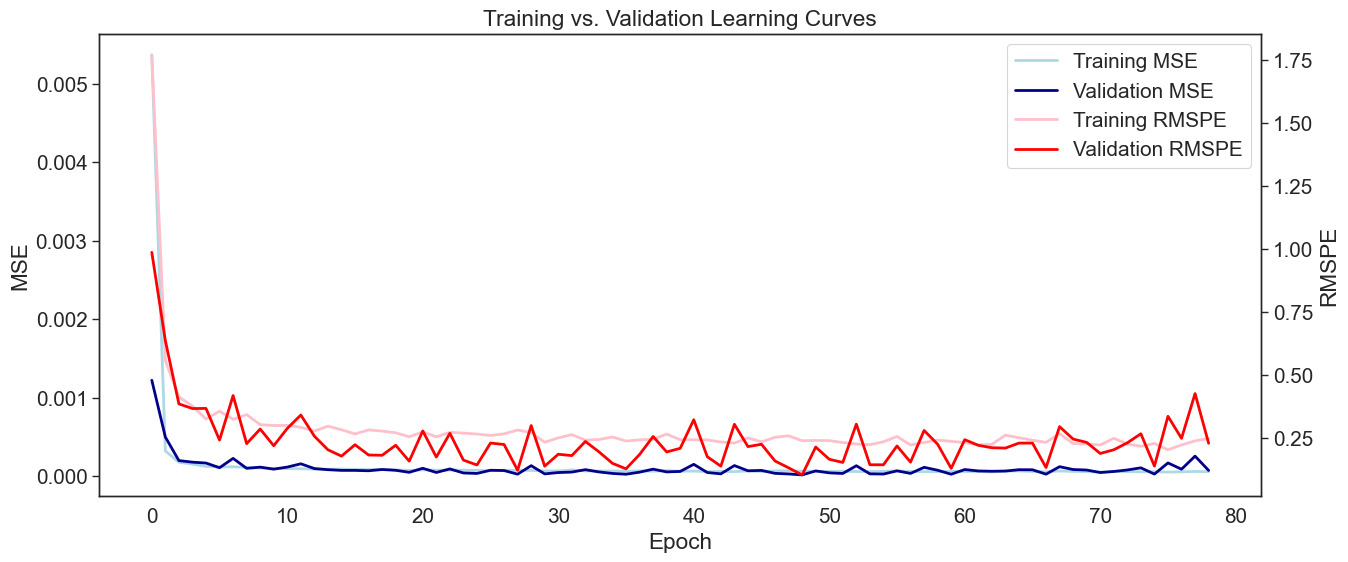

2022-01-24 00:00:00
12/12 [==============================] - 1s 9ms/step


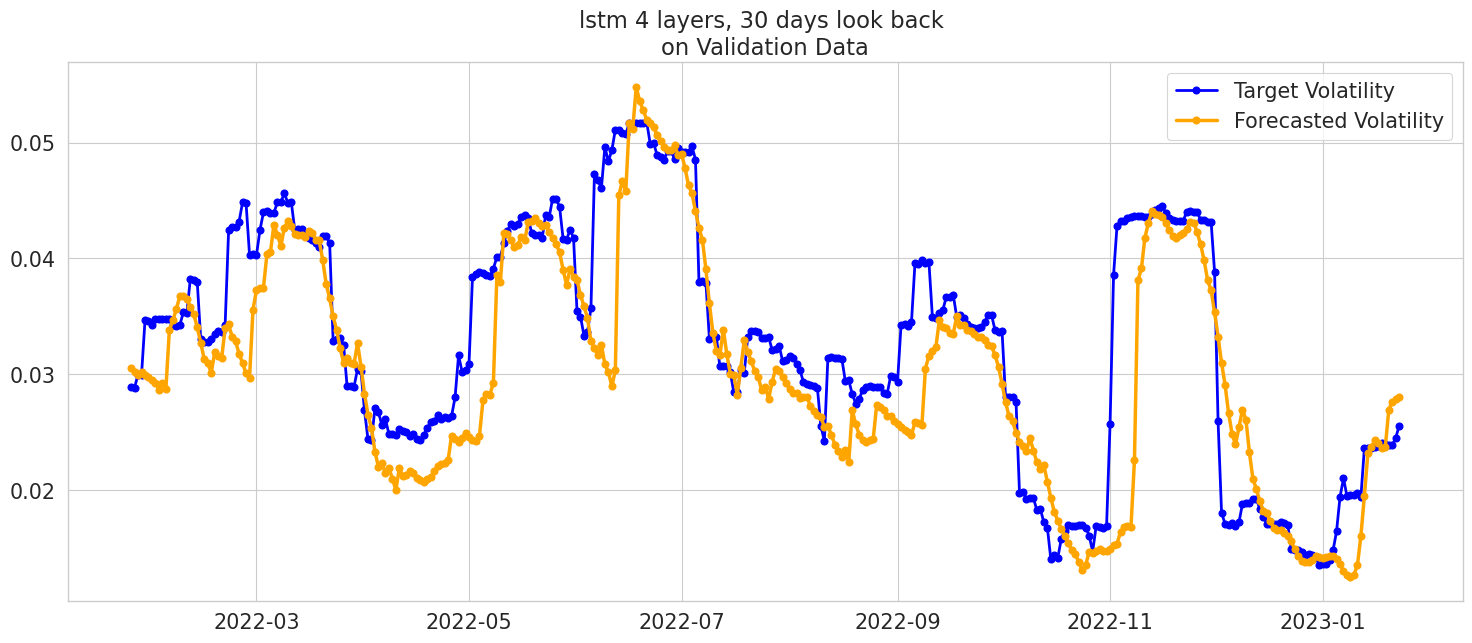

In [50]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 
    
    # SEPARATE INPUT DATAFRAME FROM df
    input_df = df[features]

    # SEPARATE INPUTS FOR TRAINING SET ONLY
    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)


    lstm_4 = tf.keras.models.Sequential([  
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
  
        tf.keras.layers.BatchNormalization(), 

        # 4th LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),
 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Dense(1)
    ])

    lstm_4.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')



        # fitting training data
    lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_4_res)

    # forecasting on validation set
    lstm_4_preds = um.forecast_multi(lstm_4, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_4_preds_scaled = um.scale(scaler_vol, lstm_4_preds)

    # plotting predictions-target
    um.viz_model(y_val['vol_future'], lstm_4_preds, 
            f"lstm 4 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_4_preds,
         f"lstm 4 layers {i}", perf_df=perf_df)
    
    i = i+1

In [51]:
# Results
perf_df.sort_values('Validation RMSPE').head(20)

Model  Validation RMSPE  Validation RMSE
8   lstm 3 layers 0          0.150788         0.005144
4   lstm 2 layers 0          0.153847         0.005011
6   lstm 2 layers 2          0.163785         0.005943
0   lstm 2 layers 0          0.170119         0.005076
12  lstm 4 layers 0          0.178508         0.005151
10  lstm 3 layers 2          0.180441         0.005454
7   lstm 2 layers 3          0.180544         0.005459
14  lstm 4 layers 2          0.180991         0.005510
15  lstm 4 layers 3          0.181374         0.006113
1   lstm 2 layers 1          0.191571         0.005256
5   lstm 2 layers 1          0.207020         0.005755
3   lstm 2 layers 3          0.212684         0.005568
2   lstm 2 layers 2          0.215779         0.005722
13  lstm 4 layers 1          0.244531         0.006044
11  lstm 3 layers 3          0.254794         0.006083
9   lstm 3 layers 1          0.292771         0.006668

### Hypertuning BI-LSTM

In [53]:
from talos import Scan

ImportError: cannot import name 'Scan' from 'talos' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/talos/__init__.py)

In [49]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # hidden layers
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[um.rmspe])
    
    # stopping the training if validation rmspe is not improving 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [50]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [52]:
tf.keras.backend.clear_session()

seed = 1234
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features_0]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = um.windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)

AttributeError: module 'talos' has no attribute 'scan'

In [ ]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)



n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())